In [195]:
import os
import sys

import featuretools as ft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
import shap
import xgboost as xgb
from scipy.stats import randint, uniform
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import (KFold, RandomizedSearchCV,
                                     StratifiedKFold, cross_val_score,
                                     train_test_split)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
import cupy as cp

ROOT = os.path.abspath(os.path.join(os.pardir))
if ROOT not in sys.path:
    sys.path.append(ROOT)

from src.config import config
from src.E2EPipeline import E2EPipeline

pd.set_option('display.max_columns', None)

# update jupyter kernel automatically
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)


task = pd.read_excel("../data/Assessment.xlsx",
                       engine='openpyxl',
                       sheet_name=0)
task

,Business Problem
0,The bank is always interested to increase customer base in different segments to up sell or X-sell the products and as part of it they want to upgrade the segment of the ETB(Exsisting To Bank) customers from Normal to Affluent for Upselling the relevant products to the prospective customers and help to increase bank revenue. So as a senior data scientist need to identify the hidden affluent customers from the Data for the bank to approach them for upgrading their segment.
1,NaN
2,Instructions:
3,1. Analysis of the data
4,2. Data Processing techniques if any
5,3.Modelling Approach(Modelling techniques used atleast 2 different modelling techniques and their comparision on different Model Evaluation metrics)
6,4.Coding scripts along with output(Jupyter notebook with the outputs included). Please Use Python for coding.
7,5.Summary of the Analysis and Business recommendations if any
8,"6. Explain the high level Mlops steps on productionalizing the Model output, Monitoring and CI/CD of the model"
9,7. Provide all the above requested Information in presentation slides except for the code scripts


In [197]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

meta = pd.read_excel("../data/Assessment.xlsx",
                       engine='openpyxl',
                       sheet_name=2)
meta

,Feature,Definition,Remarks
0,C_ID,Dummy customer ID,NaN
1,C_AGE,customer Age,NaN
2,C_EDU,customer Education,NaN
3,C_HSE,customer house type,NaN
4,PC,dummy postal code,NaN
5,INCM_TYP,income level code,NaN
6,gn_occ,occupation,NaN
7,NUM_PRD,number of distinct products held,"eg. Count of Savings, TD,Investment,Insurance etc."
8,CASATD_CNT,number of Current/savings(CASA) and Time deposit accounts held,NaN
9,MTHCASA,average monthly balance in CASA,NaN


In [198]:
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_rows', 20)

df_raw = pd.read_excel("../data/Assessment.xlsx",
                       engine='openpyxl',
                       sheet_name=1)
df_raw.head()

,C_ID,C_AGE,C_EDU,C_HSE,PC,INCM_TYP,gn_occ,NUM_PRD,CASATD_CNT,MTHCASA,MAXCASA,MINCASA,DRvCR,MTHTD,MAXTD,Asset value,HL_tag,AL_tag,pur_price_avg,UT_AVE,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT,C_seg
0,1443,65,Masters,EXECUTIVE CONDOM...,19250.0,6.0,PMEB,3,8.0,6896.91,4899.08,910.88,1.020768e+06,105000.00,25000.00,111896.91,NaN,NaN,NaN,NaN,NaN,NaN,13.233333,NaN,NaN,NaN,NaN,NaN,34500.0,AFFLUENT
1,1559,86,O-Levels,PRIVATE CONDOMINIUM,99018.0,2.0,PMEB,4,13.0,51714.78,35740.55,1318.25,8.326420e+00,575571.97,135026.15,627286.75,NaN,NaN,NaN,NaN,NaN,NaN,727.629167,8530.88,273.44,2296.713333,27560.56,88.0,4000.0,AFFLUENT
2,1913,69,A-Levels,NaN,10155.0,3.0,PMEB,4,1.0,5420.09,5420.09,5420.09,4.106600e-01,NaN,NaN,64161.74,NaN,NaN,NaN,58424.550000,59600.88,1.0,367.389167,523.35,122.13,283.580833,3402.97,78.0,5000.0,AFFLUENT
3,2032,70,NaN,NaN,21863.0,2.0,RETIREE,3,1.0,13596.65,13596.65,13596.65,5.397180e+03,NaN,NaN,39792.30,NaN,NaN,NaN,28863.181667,33902.58,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT
4,2048,72,O-Levels,EXECUTIVE CONDOM...,10641.0,NaN,BLUE COLLAR,4,2.0,51639.18,32689.93,18949.25,3.607580e+03,NaN,NaN,67258.47,NaN,NaN,NaN,15060.339167,15619.29,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT


In [199]:
# check target var distribution --> imbalance
df_raw.C_seg.value_counts()

C_seg
NORMAL      55157
AFFLUENT    10926
Name: count, dtype: int64

In [200]:
df_raw.shape

(66083, 30)

In [201]:
# C_ID is not unique
df_raw.loc[df_raw.C_ID == 59688]

,C_ID,C_AGE,C_EDU,C_HSE,PC,INCM_TYP,gn_occ,NUM_PRD,CASATD_CNT,MTHCASA,MAXCASA,MINCASA,DRvCR,MTHTD,MAXTD,Asset value,HL_tag,AL_tag,pur_price_avg,UT_AVE,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT,C_seg
7716,59688,41,NaN,NaN,11014.0,NaN,PMEB,4,2.0,8736.08,8736.08,8736.08,51293.240000,50000.0,50000.0,58736.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT
9404,59688,63,NaN,NaN,31059.0,NaN,RETIREE,2,2.0,28889.66,28889.66,28889.66,274.533333,150000.0,150000.0,178889.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFFLUENT
18364,59688,41,Degree,HDB 4-5 ROOM,80211.0,4.0,PMEB,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NORMAL
33573,59688,64,Degree,HDB 4-5 ROOM,50142.0,6.0,PMEB,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18700.0,NORMAL
37016,59688,18,NaN,NaN,89093.0,NaN,STUDENT,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NORMAL
62793,59688,38,NaN,NaN,51445.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NORMAL


In [202]:
# drop original C_ID and replace it by row index
df_raw.drop("C_ID", axis=1, inplace=True)
df_raw.reset_index(drop=True, inplace=True)
df_raw = df_raw.reset_index()
df_raw.rename(columns={"index": "C_ID"}, inplace=True)
df_raw.head()

,C_ID,C_AGE,C_EDU,C_HSE,PC,INCM_TYP,gn_occ,NUM_PRD,CASATD_CNT,MTHCASA,MAXCASA,MINCASA,DRvCR,MTHTD,MAXTD,Asset value,HL_tag,AL_tag,pur_price_avg,UT_AVE,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT,C_seg
0,0,65,Masters,EXECUTIVE CONDOM...,19250.0,6.0,PMEB,3,8.0,6896.91,4899.08,910.88,1.020768e+06,105000.00,25000.00,111896.91,NaN,NaN,NaN,NaN,NaN,NaN,13.233333,NaN,NaN,NaN,NaN,NaN,34500.0,AFFLUENT
1,1,86,O-Levels,PRIVATE CONDOMINIUM,99018.0,2.0,PMEB,4,13.0,51714.78,35740.55,1318.25,8.326420e+00,575571.97,135026.15,627286.75,NaN,NaN,NaN,NaN,NaN,NaN,727.629167,8530.88,273.44,2296.713333,27560.56,88.0,4000.0,AFFLUENT
2,2,69,A-Levels,NaN,10155.0,3.0,PMEB,4,1.0,5420.09,5420.09,5420.09,4.106600e-01,NaN,NaN,64161.74,NaN,NaN,NaN,58424.550000,59600.88,1.0,367.389167,523.35,122.13,283.580833,3402.97,78.0,5000.0,AFFLUENT
3,3,70,NaN,NaN,21863.0,2.0,RETIREE,3,1.0,13596.65,13596.65,13596.65,5.397180e+03,NaN,NaN,39792.30,NaN,NaN,NaN,28863.181667,33902.58,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT
4,4,72,O-Levels,EXECUTIVE CONDOM...,10641.0,NaN,BLUE COLLAR,4,2.0,51639.18,32689.93,18949.25,3.607580e+03,NaN,NaN,67258.47,NaN,NaN,NaN,15060.339167,15619.29,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT


In [203]:
# check col with more missing values
missing = df_raw.isnull().any(axis=0)
missing = missing.loc[missing == True].index
missing

Index(['C_EDU', 'C_HSE', 'PC', 'INCM_TYP', 'gn_occ', 'CASATD_CNT', 'MTHCASA',
       'MAXCASA', 'MINCASA', 'DRvCR', 'MTHTD', 'MAXTD', 'HL_tag', 'AL_tag',
       'pur_price_avg', 'UT_AVE', 'MAXUT', 'N_FUNDS', 'CC_AVE',
       'MAX_MTH_TRN_AMT', 'MIN_MTH_TRN_AMT', 'AVG_TRN_AMT', 'ANN_TRN_AMT',
       'ANN_N_TRX', 'CC_LMT'],
      dtype='object')

In [204]:
missing.shape

(25,)

In [205]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66083 entries, 0 to 66082
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   C_ID             66083 non-null  int64  
 1   C_AGE            66083 non-null  int64  
 2   C_EDU            27619 non-null  object 
 3   C_HSE            22167 non-null  object 
 4   PC               65597 non-null  float64
 5   INCM_TYP         36617 non-null  float64
 6   gn_occ           65205 non-null  object 
 7   NUM_PRD          66083 non-null  int64  
 8   CASATD_CNT       40991 non-null  float64
 9   MTHCASA          39045 non-null  float64
 10  MAXCASA          39045 non-null  float64
 11  MINCASA          39045 non-null  float64
 12  DRvCR            29708 non-null  float64
 13  MTHTD            14100 non-null  float64
 14  MAXTD            14100 non-null  float64
 15  Asset value      66083 non-null  float64
 16  HL_tag           2368 non-null   float64
 17  AL_tag      

In [206]:
for col in missing:
    print(f"for col - {col}:")
    print(df_raw[col].value_counts())
    print("")


for col - C_EDU:
C_EDU
Degree                                 11222
Diploma                                 6329
O-Levels                                3928
Masters                                 2628
A-Levels                                1177
Others                                   973
Below O-Levels                           422
Professional Qualifications              383
PHD/Doctorate                            367
Technical/Vocational Qualifications      190
Name: count, dtype: int64

for col - C_HSE:
C_HSE
HDB 4-5 ROOM                            15257
PRIVATE CONDOMINIUM                      3431
SEMI-DETACHED                            2406
TERRACE                                   486
SHOPHOUSE                                 138
EXECUTIVE CONDOMINIUM                      98
PRIVATE APARTMENT                          97
HDB 1-3 ROOM                               95
HDB EXECUTIVE APARTMENT/ MANSIONETTE       94
BUNGALOW                                   61
INDUSTRIAL BUILDI

In [207]:
bad_cols = []
worse_cols = []

for col in missing:
    print(f"for col - {col}:")
    ratio = sum(df_raw[col].isnull()) / df_raw.shape[0]
    print(f"missing ratio: {ratio}")
    if ratio > 0.5:
        bad_cols.append(col)
    if ratio > 0.9:
        worse_cols.append(col)

for col - C_EDU:
missing ratio: 0.5820558993992403
for col - C_HSE:
missing ratio: 0.6645582071031885
for col - PC:
missing ratio: 0.0073543876639983055
for col - INCM_TYP:
missing ratio: 0.4458938002209343
for col - gn_occ:
missing ratio: 0.013286321746894057
for col - CASATD_CNT:
missing ratio: 0.3797043112449495
for col - MTHCASA:
missing ratio: 0.4091521268707534
for col - MAXCASA:
missing ratio: 0.4091521268707534
for col - MINCASA:
missing ratio: 0.4091521268707534
for col - DRvCR:
missing ratio: 0.5504441384319719
for col - MTHTD:
missing ratio: 0.7866319628346171
for col - MAXTD:
missing ratio: 0.7866319628346171
for col - HL_tag:
missing ratio: 0.9641662757441399
for col - AL_tag:
missing ratio: 0.9154548068338302
for col - pur_price_avg:
missing ratio: 0.9154850718036409
for col - UT_AVE:
missing ratio: 0.9594752054234826
for col - MAXUT:
missing ratio: 0.9594752054234826
for col - N_FUNDS:
missing ratio: 0.9594752054234826
for col - CC_AVE:
missing ratio: 0.7416430852110225


In [208]:
len(bad_cols)

17

In [209]:
len(worse_cols)

6

In [210]:
worse_cols

['HL_tag', 'AL_tag', 'pur_price_avg', 'UT_AVE', 'MAXUT', 'N_FUNDS']

In [211]:
# impute the missing value with 0
df_raw["HL_tag"].fillna(value=0, inplace=True)
df_raw["AL_tag"].fillna(value=0, inplace=True)

In [212]:
# remove this col as it's a dummy
df_raw["PC"].value_counts()

PC
0.0        2082
10147.0      35
34.0         31
21102.0      31
21.0         29
           ... 
58788.0       1
86142.0       1
5873.0        1
49474.0       1
41686.0       1
Name: count, Length: 16046, dtype: int64

In [213]:
df_raw.drop("PC", axis=1, inplace=True)

In [214]:
df_raw.HL_tag.value_counts()

HL_tag
0.0    63715
1.0     2368
Name: count, dtype: int64

In [215]:
# define columns' categories
nominal = ["C_EDU", "C_HSE", "gn_occ", "HL_tag", "AL_tag", "C_seg"]
ordinal = ["INCM_TYP"]
target_name = "C_seg"
index_col = "C_ID"

In [216]:
interval_cols = [col for col in df_raw.columns if col not in (nominal + ordinal)]
interval_cols

['C_ID',
 'C_AGE',
 'NUM_PRD',
 'CASATD_CNT',
 'MTHCASA',
 'MAXCASA',
 'MINCASA',
 'DRvCR',
 'MTHTD',
 'MAXTD',
 'Asset value',
 'pur_price_avg',
 'UT_AVE',
 'MAXUT',
 'N_FUNDS',
 'CC_AVE',
 'MAX_MTH_TRN_AMT',
 'MIN_MTH_TRN_AMT',
 'AVG_TRN_AMT',
 'ANN_TRN_AMT',
 'ANN_N_TRX',
 'CC_LMT']

Text(0.5, 1.0, 'Correlation matrix')

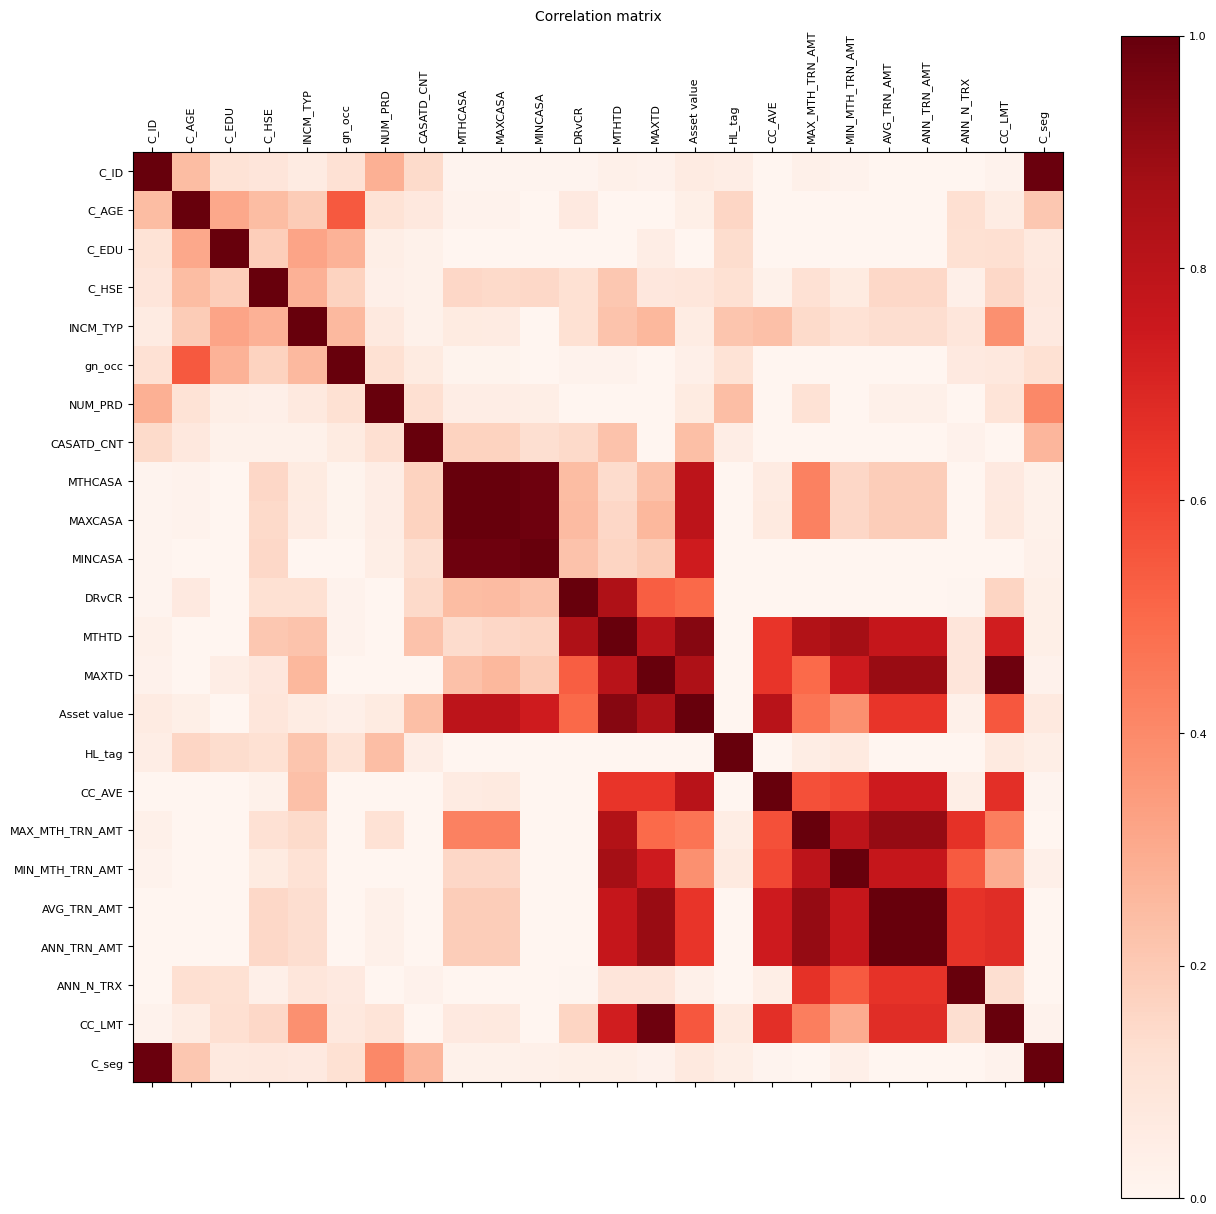

In [217]:
# explore overall correlations
df_corr = df_raw.loc[:, [c for c in df_raw.columns if c not in ["AL_tag", "pur_price_avg", "UT_AVE", "MAXUT", "N_FUNDS"]]]
phik_overview = df_corr.phik_matrix(interval_cols=interval_cols)
f = plt.figure(figsize=(15, 15))
plt.matshow(phik_overview, fignum=f.number, cmap="Reds")
plt.xticks(range(df_corr.shape[1]), df_corr.columns, fontsize=8, rotation=90)
plt.yticks(range(df_corr.shape[1]), df_corr.columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Correlation matrix', fontsize=10)

In [218]:
# C_seg is relatively more correlated with C_AGE, gn_occ, NUM_PRD, CASATD_CNT

In [219]:
# convert categorical to string
for col in (nominal + ordinal):
    df_raw[col] = df_raw[col].astype(str)

df_raw.head(2)

,C_ID,C_AGE,C_EDU,C_HSE,INCM_TYP,gn_occ,NUM_PRD,CASATD_CNT,MTHCASA,MAXCASA,MINCASA,DRvCR,MTHTD,MAXTD,Asset value,HL_tag,AL_tag,pur_price_avg,UT_AVE,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT,C_seg
0,0,65,Masters,EXECUTIVE CONDOM...,6.0,PMEB,3,8.0,6896.91,4899.08,910.88,1.020768e+06,105000.00,25000.00,111896.91,0.0,0.0,NaN,NaN,NaN,NaN,13.233333,NaN,NaN,NaN,NaN,NaN,34500.0,AFFLUENT
1,1,86,O-Levels,PRIVATE CONDOMINIUM,2.0,PMEB,4,13.0,51714.78,35740.55,1318.25,8.326420e+00,575571.97,135026.15,627286.75,0.0,0.0,NaN,NaN,NaN,NaN,727.629167,8530.88,273.44,2296.713333,27560.56,88.0,4000.0,AFFLUENT


In [220]:
# After converting, np.nan has been converted to string as well
df_raw.loc[(df_raw.isin(["nan", "NaN", "NA", "Nan", "Nill", "NAN"])).any(axis=1)]


,C_ID,C_AGE,C_EDU,C_HSE,INCM_TYP,gn_occ,NUM_PRD,CASATD_CNT,MTHCASA,MAXCASA,MINCASA,DRvCR,MTHTD,MAXTD,Asset value,HL_tag,AL_tag,pur_price_avg,UT_AVE,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT,C_seg
2,2,69,A-Levels,nan,3.0,PMEB,4,1.0,5420.09,5420.09,5420.09,0.41066,NaN,NaN,64161.74,0.0,0.0,NaN,58424.550000,59600.88,1.0,367.389167,523.35,122.13,283.580833,3402.97,78.0,5000.0,AFFLUENT
3,3,70,nan,nan,2.0,RETIREE,3,1.0,13596.65,13596.65,13596.65,5397.18000,NaN,NaN,39792.30,0.0,0.0,NaN,28863.181667,33902.58,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT
4,4,72,O-Levels,EXECUTIVE CONDOM...,nan,BLUE COLLAR,4,2.0,51639.18,32689.93,18949.25,3607.58000,NaN,NaN,67258.47,0.0,0.0,NaN,15060.339167,15619.29,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT
5,5,69,nan,nan,nan,RETIREE,3,1.0,79945.77,79945.77,79945.77,26.70592,NaN,NaN,129945.77,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT
6,6,72,nan,nan,nan,RETIREE,5,2.0,10662.29,10652.39,9.90,25290.15000,NaN,NaN,35584.40,0.0,0.0,NaN,24936.747500,25949.96,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66077,66077,32,nan,nan,nan,PMEB,2,1.0,952.17,952.17,952.17,NaN,NaN,NaN,952.17,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NORMAL
66078,66078,41,nan,nan,nan,BLUE COLLAR,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NORMAL
66079,66079,39,nan,nan,4.0,PMEB,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NORMAL
66080,66080,50,nan,nan,6.0,PMEB,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0,1.0,285999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NORMAL


In [221]:
# map string back to np.nan
df_raw.replace({"nan": np.nan, "NaN": np.nan, "NAN": np.nan}, inplace=True)

In [222]:
df_raw.head()

,C_ID,C_AGE,C_EDU,C_HSE,INCM_TYP,gn_occ,NUM_PRD,CASATD_CNT,MTHCASA,MAXCASA,MINCASA,DRvCR,MTHTD,MAXTD,Asset value,HL_tag,AL_tag,pur_price_avg,UT_AVE,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT,C_seg
0,0,65,Masters,EXECUTIVE CONDOM...,6.0,PMEB,3,8.0,6896.91,4899.08,910.88,1.020768e+06,105000.00,25000.00,111896.91,0.0,0.0,NaN,NaN,NaN,NaN,13.233333,NaN,NaN,NaN,NaN,NaN,34500.0,AFFLUENT
1,1,86,O-Levels,PRIVATE CONDOMINIUM,2.0,PMEB,4,13.0,51714.78,35740.55,1318.25,8.326420e+00,575571.97,135026.15,627286.75,0.0,0.0,NaN,NaN,NaN,NaN,727.629167,8530.88,273.44,2296.713333,27560.56,88.0,4000.0,AFFLUENT
2,2,69,A-Levels,NaN,3.0,PMEB,4,1.0,5420.09,5420.09,5420.09,4.106600e-01,NaN,NaN,64161.74,0.0,0.0,NaN,58424.550000,59600.88,1.0,367.389167,523.35,122.13,283.580833,3402.97,78.0,5000.0,AFFLUENT
3,3,70,NaN,NaN,2.0,RETIREE,3,1.0,13596.65,13596.65,13596.65,5.397180e+03,NaN,NaN,39792.30,0.0,0.0,NaN,28863.181667,33902.58,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT
4,4,72,O-Levels,EXECUTIVE CONDOM...,NaN,BLUE COLLAR,4,2.0,51639.18,32689.93,18949.25,3.607580e+03,NaN,NaN,67258.47,0.0,0.0,NaN,15060.339167,15619.29,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT


In [223]:
# prepare list of features for feature engineering
counts = [
    "NUM_PRD",
    "CASATD_CNT",
    "N_FUNDS",
    "ANN_N_TRX",
    ]

values = [
    "MTHCASA",
    "MAXCASA",
    "MINCASA",
    "pur_price_avg",
    "UT_AVE",
    "MAXUT",
    "CC_AVE",
    "MAX_MTH_TRN_AMT",
    "MIN_MTH_TRN_AMT",
    "MTHTD",
    "MAXTD",
    "Asset value",
    "AVG_TRN_AMT",
    "ANN_TRN_AMT",
    "CC_LMT",
    ]

# show the numeric columns not included in feature engineering list
[col for col in df_raw.columns if ((df_raw[col].dtype != "O") and (col not in counts + values))]

['C_ID', 'C_AGE', 'DRvCR']

In [224]:
df_raw.head()

,C_ID,C_AGE,C_EDU,C_HSE,INCM_TYP,gn_occ,NUM_PRD,CASATD_CNT,MTHCASA,MAXCASA,MINCASA,DRvCR,MTHTD,MAXTD,Asset value,HL_tag,AL_tag,pur_price_avg,UT_AVE,MAXUT,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT,C_seg
0,0,65,Masters,EXECUTIVE CONDOM...,6.0,PMEB,3,8.0,6896.91,4899.08,910.88,1.020768e+06,105000.00,25000.00,111896.91,0.0,0.0,NaN,NaN,NaN,NaN,13.233333,NaN,NaN,NaN,NaN,NaN,34500.0,AFFLUENT
1,1,86,O-Levels,PRIVATE CONDOMINIUM,2.0,PMEB,4,13.0,51714.78,35740.55,1318.25,8.326420e+00,575571.97,135026.15,627286.75,0.0,0.0,NaN,NaN,NaN,NaN,727.629167,8530.88,273.44,2296.713333,27560.56,88.0,4000.0,AFFLUENT
2,2,69,A-Levels,NaN,3.0,PMEB,4,1.0,5420.09,5420.09,5420.09,4.106600e-01,NaN,NaN,64161.74,0.0,0.0,NaN,58424.550000,59600.88,1.0,367.389167,523.35,122.13,283.580833,3402.97,78.0,5000.0,AFFLUENT
3,3,70,NaN,NaN,2.0,RETIREE,3,1.0,13596.65,13596.65,13596.65,5.397180e+03,NaN,NaN,39792.30,0.0,0.0,NaN,28863.181667,33902.58,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT
4,4,72,O-Levels,EXECUTIVE CONDOM...,NaN,BLUE COLLAR,4,2.0,51639.18,32689.93,18949.25,3.607580e+03,NaN,NaN,67258.47,0.0,0.0,NaN,15060.339167,15619.29,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,AFFLUENT


In [225]:
# prepare df for standardization
stand_cols = counts + values + ['C_AGE', 'DRvCR']
df_stand = df_raw.loc[:, stand_cols]
df_raw.drop(stand_cols, axis=1, inplace=True)
df_stand.head()

,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR
0,3,8.0,NaN,NaN,6896.91,4899.08,910.88,NaN,NaN,NaN,13.233333,NaN,NaN,105000.00,25000.00,111896.91,NaN,NaN,34500.0,65,1.020768e+06
1,4,13.0,NaN,88.0,51714.78,35740.55,1318.25,NaN,NaN,NaN,727.629167,8530.88,273.44,575571.97,135026.15,627286.75,2296.713333,27560.56,4000.0,86,8.326420e+00
2,4,1.0,1.0,78.0,5420.09,5420.09,5420.09,NaN,58424.550000,59600.88,367.389167,523.35,122.13,NaN,NaN,64161.74,283.580833,3402.97,5000.0,69,4.106600e-01
3,3,1.0,1.0,NaN,13596.65,13596.65,13596.65,NaN,28863.181667,33902.58,NaN,NaN,NaN,NaN,NaN,39792.30,NaN,NaN,0.0,70,5.397180e+03
4,4,2.0,1.0,NaN,51639.18,32689.93,18949.25,NaN,15060.339167,15619.29,NaN,NaN,NaN,NaN,NaN,67258.47,NaN,NaN,0.0,72,3.607580e+03


In [226]:
# standardize features
scaler = StandardScaler()
feature_arr = scaler.fit_transform(df_stand.values)
df_stand = pd.DataFrame(feature_arr, index=df_stand.index, columns=df_stand.columns)

df_raw = pd.concat([df_raw, df_stand], axis=1)
display("after scaling", df_raw.head())

'after scaling'

,C_ID,C_EDU,C_HSE,INCM_TYP,gn_occ,HL_tag,AL_tag,C_seg,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR
0,0,Masters,EXECUTIVE CONDOM...,6.0,PMEB,0.0,0.0,AFFLUENT,0.825212,4.444256,NaN,NaN,-0.138387,-0.162113,-0.225299,NaN,NaN,NaN,-0.283094,NaN,NaN,-0.014392,-0.363364,0.653098,NaN,NaN,2.200533,0.882655,7.399066
1,1,O-Levels,PRIVATE CONDOMINIUM,2.0,PMEB,0.0,0.0,AFFLUENT,1.740064,7.987115,NaN,0.269626,0.532190,0.311976,-0.217816,NaN,NaN,NaN,-0.140692,0.717332,-0.106335,2.643474,0.579781,5.091953,0.538457,0.538457,-0.106521,2.348794,-0.275349
2,2,A-Levels,NaN,3.0,PMEB,0.0,0.0,AFFLUENT,1.740064,-0.515746,-0.486491,0.152789,-0.160484,-0.154104,-0.142468,NaN,0.234981,0.122657,-0.212499,-0.287236,-0.253505,NaN,NaN,0.241973,-0.209854,-0.209854,-0.030880,1.161920,-0.275409
3,3,NaN,NaN,2.0,RETIREE,0.0,0.0,AFFLUENT,0.825212,-0.515746,-0.486491,NaN,-0.038144,-0.028416,0.007729,NaN,-0.307797,-0.295947,NaN,NaN,NaN,NaN,NaN,0.032088,NaN,NaN,-0.409085,1.231736,-0.234834
4,4,O-Levels,EXECUTIVE CONDOM...,NaN,BLUE COLLAR,0.0,0.0,AFFLUENT,1.740064,0.192826,-0.486491,NaN,0.531059,0.265083,0.106053,NaN,-0.561232,-0.593767,NaN,NaN,NaN,NaN,NaN,0.268644,NaN,NaN,-0.409085,1.371368,-0.248289


In [227]:
df_raw.shape

(66083, 29)

In [228]:
# pd.set_option('display.max_rows', None)
# # check avail transform
# ft.list_primitives()[ft.list_primitives().type == "transform"]

In [229]:
# feature engineering 1
es = ft.EntitySet(id='ft')
es = es.add_dataframe(dataframe_name="ft", dataframe=df_raw.loc[:, values + [index_col]], index=index_col)

features_matrix,feature_names = ft.dfs(
    entityset=es,
    target_dataframe_name='ft',
    trans_primitives=["add_numeric", "subtract_numeric", "divide_numeric",'multiply_numeric'],
    max_depth=2,
    verbose=True)

features_matrix.reset_index(inplace=True)
features_matrix = features_matrix.drop(values, axis=1)

df_raw = df_raw.merge(features_matrix, how='left', on=index_col)

df_raw.head()

Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created


Built 540 features
Elapsed: 00:01 | Progress: 100%|██████████


,C_ID,C_EDU,C_HSE,INCM_TYP,gn_occ,HL_tag,AL_tag,C_seg,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR,ANN_TRN_AMT + AVG_TRN_AMT,ANN_TRN_AMT + Asset value,ANN_TRN_AMT + CC_AVE,ANN_TRN_AMT + CC_LMT,ANN_TRN_AMT + MAXCASA,ANN_TRN_AMT + MAXTD,ANN_TRN_AMT + MAXUT,ANN_TRN_AMT + MAX_MTH_TRN_AMT,ANN_TRN_AMT + MINCASA,ANN_TRN_AMT + MIN_MTH_TRN_AMT,ANN_TRN_AMT + MTHCASA,ANN_TRN_AMT + MTHTD,ANN_TRN_AMT + UT_AVE,ANN_TRN_AMT + pur_price_avg,AVG_TRN_AMT + CC_AVE,AVG_TRN_AMT + CC_LMT,AVG_TRN_AMT + MAXCASA,AVG_TRN_AMT + MAXTD,AVG_TRN_AMT + MAXUT,AVG_TRN_AMT + MAX_MTH_TRN_AMT,AVG_TRN_AMT + MINCASA,AVG_TRN_AMT + MIN_MTH_TRN_AMT,AVG_TRN_AMT + MTHCASA,AVG_TRN_AMT + MTHTD,AVG_TRN_AMT + UT_AVE,AVG_TRN_AMT + pur_price_avg,Asset value + AVG_TRN_AMT,Asset value + CC_AVE,Asset value + CC_LMT,Asset value + MAXCASA,Asset value + MAXTD,Asset value + MAXUT,Asset value + MAX_MTH_TRN_AMT,Asset value + MINCASA,Asset value + MIN_MTH_TRN_AMT,Asset value + MTHCASA,Asset value + MTHTD,Asset value + UT_AVE,Asset value + pur_price_avg,CC_AVE + CC_LMT,CC_AVE + MAXCASA,CC_AVE + MAXTD,CC_AVE + MAXUT,CC_AVE + MAX_MTH_TRN_AMT,CC_AVE + MINCASA,CC_AVE + MIN_MTH_TRN_AMT,CC_AVE + MTHCASA,CC_AVE + MTHTD,CC_AVE + UT_AVE,CC_AVE + pur_price_avg,CC_LMT + MAXCASA,CC_LMT + MAXTD,CC_LMT + MAXUT,CC_LMT + MAX_MTH_TRN_AMT,CC_LMT + MINCASA,CC_LMT + MIN_MTH_TRN_AMT,CC_LMT + MTHCASA,CC_LMT + MTHTD,CC_LMT + UT_AVE,CC_LMT + pur_price_avg,MAXCASA + MAXTD,MAXCASA + MAXUT,MAXCASA + MINCASA,MAXCASA + MIN_MTH_TRN_AMT,MAXCASA + MTHCASA,MAXCASA + MTHTD,MAXCASA + UT_AVE,MAXCASA + pur_price_avg,MAXTD + MAXUT,MAXTD + MINCASA,MAXTD + MIN_MTH_TRN_AMT,MAXTD + MTHCASA,MAXTD + MTHTD,MAXTD + UT_AVE,MAXTD + pur_price_avg,MAXUT + MINCASA,MAXUT + MIN_MTH_TRN_AMT,MAXUT + MTHCASA,MAXUT + MTHTD,MAXUT + UT_AVE,MAXUT + pur_price_avg,MAX_MTH_TRN_AMT + MAXCASA,MAX_MTH_TRN_AMT + MAXTD,MAX_MTH_TRN_AMT + MAXUT,MAX_MTH_TRN_AMT + MINCASA,MAX_MTH_TRN_AMT + MIN_MTH_TRN_AMT,MAX_MTH_TRN_AMT + MTHCASA,MAX_MTH_TRN_AMT + MTHTD,MAX_MTH_TRN_AMT + UT_AVE,MAX_MTH_TRN_AMT + pur_price_avg,MINCASA + MTHCASA,MINCASA + MTHTD,MINCASA + UT_AVE,MINCASA + pur_price_avg,MIN_MTH_TRN_AMT + MINCASA,MIN_MTH_TRN_AMT + MTHCASA,MIN_MTH_TRN_AMT + MTHTD,MIN_MTH_TRN_AMT + UT_AVE,MIN_MTH_TRN_AMT + pur_price_avg,MTHCASA + MTHTD,MTHCASA + UT_AVE,MTHCASA + pur_price_avg,MTHTD + UT_AVE,MTHTD + pur_price_avg,pur_price_avg + UT_AVE,ANN_TRN_AMT / AVG_TRN_AMT,ANN_TRN_AMT / Asset value,ANN_TRN_AMT / CC_AVE,ANN_TRN_AMT / CC_LMT,ANN_TRN_AMT / MAXCASA,ANN_TRN_AMT / MAXTD,ANN_TRN_AMT / MAXUT,ANN_TRN_AMT / MAX_MTH_TRN_AMT,ANN_TRN_AMT / MINCASA,ANN_TRN_AMT / MIN_MTH_TRN_AMT,ANN_TRN_AMT / MTHCASA,ANN_TRN_AMT / MTHTD,ANN_TRN_AMT / UT_AVE,ANN_TRN_AMT / pur_price_avg,AVG_TRN_AMT / ANN_TRN_AMT,AVG_TRN_AMT / Asset value,AVG_TRN_AMT / CC_AVE,AVG_TRN_AMT / CC_LMT,AVG_TRN_AMT / MAXCASA,AVG_TRN_AMT / MAXTD,AVG_TRN_AMT / MAXUT,AVG_TRN_AMT / MAX_MTH_TRN_AMT,AVG_TRN_AMT / MINCASA,AVG_TRN_AMT / MIN_MTH_TRN_AMT,AVG_TRN_AMT / MTHCASA,AVG_TRN_AMT / MTHTD,AVG_TRN_AMT / UT_AVE,AVG_TRN_AMT / pur_price_avg,Asset value / ANN_TRN_AMT,Asset value / AVG_TRN_AMT,Asset value / CC_AVE,Asset value / CC_LMT,Asset value / MAXCASA,Asset value / MAXTD,Asset value / MAXUT,Asset value / MAX_MTH_TRN_AMT,Asset value / MINCASA,Asset value / MIN_MTH_TRN_AMT,Asset value / MTHCASA,Asset value / MTHTD,Asset value / UT_AVE,Asset value / pur_price_avg,CC_AVE / ANN_TRN_AMT,CC_AVE / AVG_TRN_AMT,CC_AVE / Asset value,CC_AVE / CC_LMT,CC_AVE / MAXCASA,CC_AVE / MAXTD,CC_AVE / MAXUT,CC_AVE / MAX_MTH_TRN_AMT,CC_AVE / MINCASA,CC_AVE / MIN_MTH_TRN_AMT,CC_AVE / MTHCASA,CC_AVE / MTHTD,CC_AVE / UT_AVE,CC_AVE / pur_price_avg,CC_LMT / ANN_TRN_AMT,CC_LMT / AVG_TRN_AMT,CC_LMT / Asset value,CC_LMT / CC_AVE,CC_LMT / MAXCASA,CC_LMT / MAXTD,CC_LMT / MAXUT,CC_LMT / MAX_MTH_TRN_AMT,CC_LMT / MINCASA,CC_LMT / MIN_MTH_TRN_AMT,CC_LMT / MTHCASA,CC_LMT / MTHTD,CC_LMT / UT_AVE,CC_LMT / pur_price_a

In [230]:
# feature engineering 2
es = ft.EntitySet(id='ft')
es = es.add_dataframe(dataframe_name="ft", dataframe=df_raw.loc[:, counts + [index_col]], index=index_col)

features_matrix,feature_names = ft.dfs(
    entityset=es,
    target_dataframe_name='ft',
    trans_primitives=["add_numeric", "subtract_numeric", "divide_numeric",'multiply_numeric'],
    max_depth=2,
    verbose=True)

features_matrix.reset_index(inplace=True)
features_matrix = features_matrix.drop(counts, axis=1)

df_raw = df_raw.merge(features_matrix, how='left', on=index_col)

df_raw.head()

Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created


Built 34 features
Elapsed: 00:00 | Progress: 100%|██████████


,C_ID,C_EDU,C_HSE,INCM_TYP,gn_occ,HL_tag,AL_tag,C_seg,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR,ANN_TRN_AMT + AVG_TRN_AMT,ANN_TRN_AMT + Asset value,ANN_TRN_AMT + CC_AVE,ANN_TRN_AMT + CC_LMT,ANN_TRN_AMT + MAXCASA,ANN_TRN_AMT + MAXTD,ANN_TRN_AMT + MAXUT,ANN_TRN_AMT + MAX_MTH_TRN_AMT,ANN_TRN_AMT + MINCASA,ANN_TRN_AMT + MIN_MTH_TRN_AMT,ANN_TRN_AMT + MTHCASA,ANN_TRN_AMT + MTHTD,ANN_TRN_AMT + UT_AVE,ANN_TRN_AMT + pur_price_avg,AVG_TRN_AMT + CC_AVE,AVG_TRN_AMT + CC_LMT,AVG_TRN_AMT + MAXCASA,AVG_TRN_AMT + MAXTD,AVG_TRN_AMT + MAXUT,AVG_TRN_AMT + MAX_MTH_TRN_AMT,AVG_TRN_AMT + MINCASA,AVG_TRN_AMT + MIN_MTH_TRN_AMT,AVG_TRN_AMT + MTHCASA,AVG_TRN_AMT + MTHTD,AVG_TRN_AMT + UT_AVE,AVG_TRN_AMT + pur_price_avg,Asset value + AVG_TRN_AMT,Asset value + CC_AVE,Asset value + CC_LMT,Asset value + MAXCASA,Asset value + MAXTD,Asset value + MAXUT,Asset value + MAX_MTH_TRN_AMT,Asset value + MINCASA,Asset value + MIN_MTH_TRN_AMT,Asset value + MTHCASA,Asset value + MTHTD,Asset value + UT_AVE,Asset value + pur_price_avg,CC_AVE + CC_LMT,CC_AVE + MAXCASA,CC_AVE + MAXTD,CC_AVE + MAXUT,CC_AVE + MAX_MTH_TRN_AMT,CC_AVE + MINCASA,CC_AVE + MIN_MTH_TRN_AMT,CC_AVE + MTHCASA,CC_AVE + MTHTD,CC_AVE + UT_AVE,CC_AVE + pur_price_avg,CC_LMT + MAXCASA,CC_LMT + MAXTD,CC_LMT + MAXUT,CC_LMT + MAX_MTH_TRN_AMT,CC_LMT + MINCASA,CC_LMT + MIN_MTH_TRN_AMT,CC_LMT + MTHCASA,CC_LMT + MTHTD,CC_LMT + UT_AVE,CC_LMT + pur_price_avg,MAXCASA + MAXTD,MAXCASA + MAXUT,MAXCASA + MINCASA,MAXCASA + MIN_MTH_TRN_AMT,MAXCASA + MTHCASA,MAXCASA + MTHTD,MAXCASA + UT_AVE,MAXCASA + pur_price_avg,MAXTD + MAXUT,MAXTD + MINCASA,MAXTD + MIN_MTH_TRN_AMT,MAXTD + MTHCASA,MAXTD + MTHTD,MAXTD + UT_AVE,MAXTD + pur_price_avg,MAXUT + MINCASA,MAXUT + MIN_MTH_TRN_AMT,MAXUT + MTHCASA,MAXUT + MTHTD,MAXUT + UT_AVE,MAXUT + pur_price_avg,MAX_MTH_TRN_AMT + MAXCASA,MAX_MTH_TRN_AMT + MAXTD,MAX_MTH_TRN_AMT + MAXUT,MAX_MTH_TRN_AMT + MINCASA,MAX_MTH_TRN_AMT + MIN_MTH_TRN_AMT,MAX_MTH_TRN_AMT + MTHCASA,MAX_MTH_TRN_AMT + MTHTD,MAX_MTH_TRN_AMT + UT_AVE,MAX_MTH_TRN_AMT + pur_price_avg,MINCASA + MTHCASA,MINCASA + MTHTD,MINCASA + UT_AVE,MINCASA + pur_price_avg,MIN_MTH_TRN_AMT + MINCASA,MIN_MTH_TRN_AMT + MTHCASA,MIN_MTH_TRN_AMT + MTHTD,MIN_MTH_TRN_AMT + UT_AVE,MIN_MTH_TRN_AMT + pur_price_avg,MTHCASA + MTHTD,MTHCASA + UT_AVE,MTHCASA + pur_price_avg,MTHTD + UT_AVE,MTHTD + pur_price_avg,pur_price_avg + UT_AVE,ANN_TRN_AMT / AVG_TRN_AMT,ANN_TRN_AMT / Asset value,ANN_TRN_AMT / CC_AVE,ANN_TRN_AMT / CC_LMT,ANN_TRN_AMT / MAXCASA,ANN_TRN_AMT / MAXTD,ANN_TRN_AMT / MAXUT,ANN_TRN_AMT / MAX_MTH_TRN_AMT,ANN_TRN_AMT / MINCASA,ANN_TRN_AMT / MIN_MTH_TRN_AMT,ANN_TRN_AMT / MTHCASA,ANN_TRN_AMT / MTHTD,ANN_TRN_AMT / UT_AVE,ANN_TRN_AMT / pur_price_avg,AVG_TRN_AMT / ANN_TRN_AMT,AVG_TRN_AMT / Asset value,AVG_TRN_AMT / CC_AVE,AVG_TRN_AMT / CC_LMT,AVG_TRN_AMT / MAXCASA,AVG_TRN_AMT / MAXTD,AVG_TRN_AMT / MAXUT,AVG_TRN_AMT / MAX_MTH_TRN_AMT,AVG_TRN_AMT / MINCASA,AVG_TRN_AMT / MIN_MTH_TRN_AMT,AVG_TRN_AMT / MTHCASA,AVG_TRN_AMT / MTHTD,AVG_TRN_AMT / UT_AVE,AVG_TRN_AMT / pur_price_avg,Asset value / ANN_TRN_AMT,Asset value / AVG_TRN_AMT,Asset value / CC_AVE,Asset value / CC_LMT,Asset value / MAXCASA,Asset value / MAXTD,Asset value / MAXUT,Asset value / MAX_MTH_TRN_AMT,Asset value / MINCASA,Asset value / MIN_MTH_TRN_AMT,Asset value / MTHCASA,Asset value / MTHTD,Asset value / UT_AVE,Asset value / pur_price_avg,CC_AVE / ANN_TRN_AMT,CC_AVE / AVG_TRN_AMT,CC_AVE / Asset value,CC_AVE / CC_LMT,CC_AVE / MAXCASA,CC_AVE / MAXTD,CC_AVE / MAXUT,CC_AVE / MAX_MTH_TRN_AMT,CC_AVE / MINCASA,CC_AVE / MIN_MTH_TRN_AMT,CC_AVE / MTHCASA,CC_AVE / MTHTD,CC_AVE / UT_AVE,CC_AVE / pur_price_avg,CC_LMT / ANN_TRN_AMT,CC_LMT / AVG_TRN_AMT,CC_LMT / Asset value,CC_LMT / CC_AVE,CC_LMT / MAXCASA,CC_LMT / MAXTD,CC_LMT / MAXUT,CC_LMT / MAX_MTH_TRN_AMT,CC_LMT / MINCASA,CC_LMT / MIN_MTH_TRN_AMT,CC_LMT / MTHCASA,CC_LMT / MTHTD,CC_LMT / UT_AVE,CC_LMT / pur_price_a

In [231]:
df_raw.shape

(66083, 584)

In [232]:
df_raw.replace([np.inf, -np.inf], np.nan, inplace=True)

In [233]:
# drop the customer_id
df_X = df_raw.drop([index_col, target_name], axis=1)
df_y = df_raw.loc[:, [target_name]]

In [234]:
# train, val, test split
X, X_test, y, y_test = train_test_split(df_X, df_y, test_size=0.1, random_state=config.SEED, shuffle=True, stratify=df_y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=config.SEED, shuffle=True, stratify=y)

display(f"train set size: {X_train.shape}, val set size: {X_val.shape}, test set size: {X_test.shape}")

'train set size: (53526, 582), val set size: (5948, 582), test set size: (6609, 582)'

In [235]:
# get cols requiring onehotencoding
categorical = [col for col in (ordinal + nominal) if col != target_name]
display(f"the categorical variables that need one hot encoding are: {categorical}")

# apply onehotencoding for categorical variables
enc = OneHotEncoder(handle_unknown='error', sparse_output=False, drop=None)
enc.fit_transform(df_X.loc[:, categorical])
feature_labels = enc.get_feature_names_out()


feature_arr = enc.transform(X[categorical])
cat_X = pd.DataFrame(feature_arr, columns=feature_labels).reset_index(drop=True)
X = pd.concat([X.drop(categorical, axis=1).reset_index(drop=True), cat_X], axis=1)

# for training data
feature_arr = enc.transform(X_train[categorical])
cat_train = pd.DataFrame(feature_arr, columns=feature_labels).reset_index(drop=True)
X_train = pd.concat([X_train.drop(categorical, axis=1).reset_index(drop=True), cat_train], axis=1)
display("training data after onehot encoding:", X_train.head())

feature_arr = enc.transform(X_val[categorical])
cat_val = pd.DataFrame(feature_arr, columns=feature_labels).reset_index(drop=True)
X_val = pd.concat([X_val.drop(categorical, axis=1).reset_index(drop=True), cat_val], axis=1)
display("val data after onehot encoding:", X_val.head())

feature_arr = enc.transform(X_test[categorical])
cat_test = pd.DataFrame(feature_arr, columns=feature_labels).reset_index(drop=True)
X_test = pd.concat([X_test.drop(categorical, axis=1).reset_index(drop=True), cat_test], axis=1)
display("test data after onehot encoding:", X_test.head())

"the categorical variables that need one hot encoding are: ['INCM_TYP', 'C_EDU', 'C_HSE', 'gn_occ', 'HL_tag', 'AL_tag']"

'training data after onehot encoding:'

,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR,ANN_TRN_AMT + AVG_TRN_AMT,ANN_TRN_AMT + Asset value,ANN_TRN_AMT + CC_AVE,ANN_TRN_AMT + CC_LMT,ANN_TRN_AMT + MAXCASA,ANN_TRN_AMT + MAXTD,ANN_TRN_AMT + MAXUT,ANN_TRN_AMT + MAX_MTH_TRN_AMT,ANN_TRN_AMT + MINCASA,ANN_TRN_AMT + MIN_MTH_TRN_AMT,ANN_TRN_AMT + MTHCASA,ANN_TRN_AMT + MTHTD,ANN_TRN_AMT + UT_AVE,ANN_TRN_AMT + pur_price_avg,AVG_TRN_AMT + CC_AVE,AVG_TRN_AMT + CC_LMT,AVG_TRN_AMT + MAXCASA,AVG_TRN_AMT + MAXTD,AVG_TRN_AMT + MAXUT,AVG_TRN_AMT + MAX_MTH_TRN_AMT,AVG_TRN_AMT + MINCASA,AVG_TRN_AMT + MIN_MTH_TRN_AMT,AVG_TRN_AMT + MTHCASA,AVG_TRN_AMT + MTHTD,AVG_TRN_AMT + UT_AVE,AVG_TRN_AMT + pur_price_avg,Asset value + AVG_TRN_AMT,Asset value + CC_AVE,Asset value + CC_LMT,Asset value + MAXCASA,Asset value + MAXTD,Asset value + MAXUT,Asset value + MAX_MTH_TRN_AMT,Asset value + MINCASA,Asset value + MIN_MTH_TRN_AMT,Asset value + MTHCASA,Asset value + MTHTD,Asset value + UT_AVE,Asset value + pur_price_avg,CC_AVE + CC_LMT,CC_AVE + MAXCASA,CC_AVE + MAXTD,CC_AVE + MAXUT,CC_AVE + MAX_MTH_TRN_AMT,CC_AVE + MINCASA,CC_AVE + MIN_MTH_TRN_AMT,CC_AVE + MTHCASA,CC_AVE + MTHTD,CC_AVE + UT_AVE,CC_AVE + pur_price_avg,CC_LMT + MAXCASA,CC_LMT + MAXTD,CC_LMT + MAXUT,CC_LMT + MAX_MTH_TRN_AMT,CC_LMT + MINCASA,CC_LMT + MIN_MTH_TRN_AMT,CC_LMT + MTHCASA,CC_LMT + MTHTD,CC_LMT + UT_AVE,CC_LMT + pur_price_avg,MAXCASA + MAXTD,MAXCASA + MAXUT,MAXCASA + MINCASA,MAXCASA + MIN_MTH_TRN_AMT,MAXCASA + MTHCASA,MAXCASA + MTHTD,MAXCASA + UT_AVE,MAXCASA + pur_price_avg,MAXTD + MAXUT,MAXTD + MINCASA,MAXTD + MIN_MTH_TRN_AMT,MAXTD + MTHCASA,MAXTD + MTHTD,MAXTD + UT_AVE,MAXTD + pur_price_avg,MAXUT + MINCASA,MAXUT + MIN_MTH_TRN_AMT,MAXUT + MTHCASA,MAXUT + MTHTD,MAXUT + UT_AVE,MAXUT + pur_price_avg,MAX_MTH_TRN_AMT + MAXCASA,MAX_MTH_TRN_AMT + MAXTD,MAX_MTH_TRN_AMT + MAXUT,MAX_MTH_TRN_AMT + MINCASA,MAX_MTH_TRN_AMT + MIN_MTH_TRN_AMT,MAX_MTH_TRN_AMT + MTHCASA,MAX_MTH_TRN_AMT + MTHTD,MAX_MTH_TRN_AMT + UT_AVE,MAX_MTH_TRN_AMT + pur_price_avg,MINCASA + MTHCASA,MINCASA + MTHTD,MINCASA + UT_AVE,MINCASA + pur_price_avg,MIN_MTH_TRN_AMT + MINCASA,MIN_MTH_TRN_AMT + MTHCASA,MIN_MTH_TRN_AMT + MTHTD,MIN_MTH_TRN_AMT + UT_AVE,MIN_MTH_TRN_AMT + pur_price_avg,MTHCASA + MTHTD,MTHCASA + UT_AVE,MTHCASA + pur_price_avg,MTHTD + UT_AVE,MTHTD + pur_price_avg,pur_price_avg + UT_AVE,ANN_TRN_AMT / AVG_TRN_AMT,ANN_TRN_AMT / Asset value,ANN_TRN_AMT / CC_AVE,ANN_TRN_AMT / CC_LMT,ANN_TRN_AMT / MAXCASA,ANN_TRN_AMT / MAXTD,ANN_TRN_AMT / MAXUT,ANN_TRN_AMT / MAX_MTH_TRN_AMT,ANN_TRN_AMT / MINCASA,ANN_TRN_AMT / MIN_MTH_TRN_AMT,ANN_TRN_AMT / MTHCASA,ANN_TRN_AMT / MTHTD,ANN_TRN_AMT / UT_AVE,ANN_TRN_AMT / pur_price_avg,AVG_TRN_AMT / ANN_TRN_AMT,AVG_TRN_AMT / Asset value,AVG_TRN_AMT / CC_AVE,AVG_TRN_AMT / CC_LMT,AVG_TRN_AMT / MAXCASA,AVG_TRN_AMT / MAXTD,AVG_TRN_AMT / MAXUT,AVG_TRN_AMT / MAX_MTH_TRN_AMT,AVG_TRN_AMT / MINCASA,AVG_TRN_AMT / MIN_MTH_TRN_AMT,AVG_TRN_AMT / MTHCASA,AVG_TRN_AMT / MTHTD,AVG_TRN_AMT / UT_AVE,AVG_TRN_AMT / pur_price_avg,Asset value / ANN_TRN_AMT,Asset value / AVG_TRN_AMT,Asset value / CC_AVE,Asset value / CC_LMT,Asset value / MAXCASA,Asset value / MAXTD,Asset value / MAXUT,Asset value / MAX_MTH_TRN_AMT,Asset value / MINCASA,Asset value / MIN_MTH_TRN_AMT,Asset value / MTHCASA,Asset value / MTHTD,Asset value / UT_AVE,Asset value / pur_price_avg,CC_AVE / ANN_TRN_AMT,CC_AVE / AVG_TRN_AMT,CC_AVE / Asset value,CC_AVE / CC_LMT,CC_AVE / MAXCASA,CC_AVE / MAXTD,CC_AVE / MAXUT,CC_AVE / MAX_MTH_TRN_AMT,CC_AVE / MINCASA,CC_AVE / MIN_MTH_TRN_AMT,CC_AVE / MTHCASA,CC_AVE / MTHTD,CC_AVE / UT_AVE,CC_AVE / pur_price_avg,CC_LMT / ANN_TRN_AMT,CC_LMT / AVG_TRN_AMT,CC_LMT / Asset value,CC_LMT / CC_AVE,CC_LMT / MAXCASA,CC_LMT / MAXTD,CC_LMT / MAXUT,CC_LMT / MAX_MTH_TRN_AMT,CC_LMT / MINCASA,CC_LMT / MIN_MTH_TRN_AMT,CC_LMT / MTHCASA,CC_LMT / MTHTD,CC_LMT / UT_AVE,CC_LMT / pur_price_avg,MAXCASA / ANN_TRN_AMT,MAXCASA / AVG_TRN_AMT,MAXCAS

'val data after onehot encoding:'

,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR,ANN_TRN_AMT + AVG_TRN_AMT,ANN_TRN_AMT + Asset value,ANN_TRN_AMT + CC_AVE,ANN_TRN_AMT + CC_LMT,ANN_TRN_AMT + MAXCASA,ANN_TRN_AMT + MAXTD,ANN_TRN_AMT + MAXUT,ANN_TRN_AMT + MAX_MTH_TRN_AMT,ANN_TRN_AMT + MINCASA,ANN_TRN_AMT + MIN_MTH_TRN_AMT,ANN_TRN_AMT + MTHCASA,ANN_TRN_AMT + MTHTD,ANN_TRN_AMT + UT_AVE,ANN_TRN_AMT + pur_price_avg,AVG_TRN_AMT + CC_AVE,AVG_TRN_AMT + CC_LMT,AVG_TRN_AMT + MAXCASA,AVG_TRN_AMT + MAXTD,AVG_TRN_AMT + MAXUT,AVG_TRN_AMT + MAX_MTH_TRN_AMT,AVG_TRN_AMT + MINCASA,AVG_TRN_AMT + MIN_MTH_TRN_AMT,AVG_TRN_AMT + MTHCASA,AVG_TRN_AMT + MTHTD,AVG_TRN_AMT + UT_AVE,AVG_TRN_AMT + pur_price_avg,Asset value + AVG_TRN_AMT,Asset value + CC_AVE,Asset value + CC_LMT,Asset value + MAXCASA,Asset value + MAXTD,Asset value + MAXUT,Asset value + MAX_MTH_TRN_AMT,Asset value + MINCASA,Asset value + MIN_MTH_TRN_AMT,Asset value + MTHCASA,Asset value + MTHTD,Asset value + UT_AVE,Asset value + pur_price_avg,CC_AVE + CC_LMT,CC_AVE + MAXCASA,CC_AVE + MAXTD,CC_AVE + MAXUT,CC_AVE + MAX_MTH_TRN_AMT,CC_AVE + MINCASA,CC_AVE + MIN_MTH_TRN_AMT,CC_AVE + MTHCASA,CC_AVE + MTHTD,CC_AVE + UT_AVE,CC_AVE + pur_price_avg,CC_LMT + MAXCASA,CC_LMT + MAXTD,CC_LMT + MAXUT,CC_LMT + MAX_MTH_TRN_AMT,CC_LMT + MINCASA,CC_LMT + MIN_MTH_TRN_AMT,CC_LMT + MTHCASA,CC_LMT + MTHTD,CC_LMT + UT_AVE,CC_LMT + pur_price_avg,MAXCASA + MAXTD,MAXCASA + MAXUT,MAXCASA + MINCASA,MAXCASA + MIN_MTH_TRN_AMT,MAXCASA + MTHCASA,MAXCASA + MTHTD,MAXCASA + UT_AVE,MAXCASA + pur_price_avg,MAXTD + MAXUT,MAXTD + MINCASA,MAXTD + MIN_MTH_TRN_AMT,MAXTD + MTHCASA,MAXTD + MTHTD,MAXTD + UT_AVE,MAXTD + pur_price_avg,MAXUT + MINCASA,MAXUT + MIN_MTH_TRN_AMT,MAXUT + MTHCASA,MAXUT + MTHTD,MAXUT + UT_AVE,MAXUT + pur_price_avg,MAX_MTH_TRN_AMT + MAXCASA,MAX_MTH_TRN_AMT + MAXTD,MAX_MTH_TRN_AMT + MAXUT,MAX_MTH_TRN_AMT + MINCASA,MAX_MTH_TRN_AMT + MIN_MTH_TRN_AMT,MAX_MTH_TRN_AMT + MTHCASA,MAX_MTH_TRN_AMT + MTHTD,MAX_MTH_TRN_AMT + UT_AVE,MAX_MTH_TRN_AMT + pur_price_avg,MINCASA + MTHCASA,MINCASA + MTHTD,MINCASA + UT_AVE,MINCASA + pur_price_avg,MIN_MTH_TRN_AMT + MINCASA,MIN_MTH_TRN_AMT + MTHCASA,MIN_MTH_TRN_AMT + MTHTD,MIN_MTH_TRN_AMT + UT_AVE,MIN_MTH_TRN_AMT + pur_price_avg,MTHCASA + MTHTD,MTHCASA + UT_AVE,MTHCASA + pur_price_avg,MTHTD + UT_AVE,MTHTD + pur_price_avg,pur_price_avg + UT_AVE,ANN_TRN_AMT / AVG_TRN_AMT,ANN_TRN_AMT / Asset value,ANN_TRN_AMT / CC_AVE,ANN_TRN_AMT / CC_LMT,ANN_TRN_AMT / MAXCASA,ANN_TRN_AMT / MAXTD,ANN_TRN_AMT / MAXUT,ANN_TRN_AMT / MAX_MTH_TRN_AMT,ANN_TRN_AMT / MINCASA,ANN_TRN_AMT / MIN_MTH_TRN_AMT,ANN_TRN_AMT / MTHCASA,ANN_TRN_AMT / MTHTD,ANN_TRN_AMT / UT_AVE,ANN_TRN_AMT / pur_price_avg,AVG_TRN_AMT / ANN_TRN_AMT,AVG_TRN_AMT / Asset value,AVG_TRN_AMT / CC_AVE,AVG_TRN_AMT / CC_LMT,AVG_TRN_AMT / MAXCASA,AVG_TRN_AMT / MAXTD,AVG_TRN_AMT / MAXUT,AVG_TRN_AMT / MAX_MTH_TRN_AMT,AVG_TRN_AMT / MINCASA,AVG_TRN_AMT / MIN_MTH_TRN_AMT,AVG_TRN_AMT / MTHCASA,AVG_TRN_AMT / MTHTD,AVG_TRN_AMT / UT_AVE,AVG_TRN_AMT / pur_price_avg,Asset value / ANN_TRN_AMT,Asset value / AVG_TRN_AMT,Asset value / CC_AVE,Asset value / CC_LMT,Asset value / MAXCASA,Asset value / MAXTD,Asset value / MAXUT,Asset value / MAX_MTH_TRN_AMT,Asset value / MINCASA,Asset value / MIN_MTH_TRN_AMT,Asset value / MTHCASA,Asset value / MTHTD,Asset value / UT_AVE,Asset value / pur_price_avg,CC_AVE / ANN_TRN_AMT,CC_AVE / AVG_TRN_AMT,CC_AVE / Asset value,CC_AVE / CC_LMT,CC_AVE / MAXCASA,CC_AVE / MAXTD,CC_AVE / MAXUT,CC_AVE / MAX_MTH_TRN_AMT,CC_AVE / MINCASA,CC_AVE / MIN_MTH_TRN_AMT,CC_AVE / MTHCASA,CC_AVE / MTHTD,CC_AVE / UT_AVE,CC_AVE / pur_price_avg,CC_LMT / ANN_TRN_AMT,CC_LMT / AVG_TRN_AMT,CC_LMT / Asset value,CC_LMT / CC_AVE,CC_LMT / MAXCASA,CC_LMT / MAXTD,CC_LMT / MAXUT,CC_LMT / MAX_MTH_TRN_AMT,CC_LMT / MINCASA,CC_LMT / MIN_MTH_TRN_AMT,CC_LMT / MTHCASA,CC_LMT / MTHTD,CC_LMT / UT_AVE,CC_LMT / pur_price_avg,MAXCASA / ANN_TRN_AMT,MAXCASA / AVG_TRN_AMT,MAXCAS

'test data after onehot encoding:'

,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR,ANN_TRN_AMT + AVG_TRN_AMT,ANN_TRN_AMT + Asset value,ANN_TRN_AMT + CC_AVE,ANN_TRN_AMT + CC_LMT,ANN_TRN_AMT + MAXCASA,ANN_TRN_AMT + MAXTD,ANN_TRN_AMT + MAXUT,ANN_TRN_AMT + MAX_MTH_TRN_AMT,ANN_TRN_AMT + MINCASA,ANN_TRN_AMT + MIN_MTH_TRN_AMT,ANN_TRN_AMT + MTHCASA,ANN_TRN_AMT + MTHTD,ANN_TRN_AMT + UT_AVE,ANN_TRN_AMT + pur_price_avg,AVG_TRN_AMT + CC_AVE,AVG_TRN_AMT + CC_LMT,AVG_TRN_AMT + MAXCASA,AVG_TRN_AMT + MAXTD,AVG_TRN_AMT + MAXUT,AVG_TRN_AMT + MAX_MTH_TRN_AMT,AVG_TRN_AMT + MINCASA,AVG_TRN_AMT + MIN_MTH_TRN_AMT,AVG_TRN_AMT + MTHCASA,AVG_TRN_AMT + MTHTD,AVG_TRN_AMT + UT_AVE,AVG_TRN_AMT + pur_price_avg,Asset value + AVG_TRN_AMT,Asset value + CC_AVE,Asset value + CC_LMT,Asset value + MAXCASA,Asset value + MAXTD,Asset value + MAXUT,Asset value + MAX_MTH_TRN_AMT,Asset value + MINCASA,Asset value + MIN_MTH_TRN_AMT,Asset value + MTHCASA,Asset value + MTHTD,Asset value + UT_AVE,Asset value + pur_price_avg,CC_AVE + CC_LMT,CC_AVE + MAXCASA,CC_AVE + MAXTD,CC_AVE + MAXUT,CC_AVE + MAX_MTH_TRN_AMT,CC_AVE + MINCASA,CC_AVE + MIN_MTH_TRN_AMT,CC_AVE + MTHCASA,CC_AVE + MTHTD,CC_AVE + UT_AVE,CC_AVE + pur_price_avg,CC_LMT + MAXCASA,CC_LMT + MAXTD,CC_LMT + MAXUT,CC_LMT + MAX_MTH_TRN_AMT,CC_LMT + MINCASA,CC_LMT + MIN_MTH_TRN_AMT,CC_LMT + MTHCASA,CC_LMT + MTHTD,CC_LMT + UT_AVE,CC_LMT + pur_price_avg,MAXCASA + MAXTD,MAXCASA + MAXUT,MAXCASA + MINCASA,MAXCASA + MIN_MTH_TRN_AMT,MAXCASA + MTHCASA,MAXCASA + MTHTD,MAXCASA + UT_AVE,MAXCASA + pur_price_avg,MAXTD + MAXUT,MAXTD + MINCASA,MAXTD + MIN_MTH_TRN_AMT,MAXTD + MTHCASA,MAXTD + MTHTD,MAXTD + UT_AVE,MAXTD + pur_price_avg,MAXUT + MINCASA,MAXUT + MIN_MTH_TRN_AMT,MAXUT + MTHCASA,MAXUT + MTHTD,MAXUT + UT_AVE,MAXUT + pur_price_avg,MAX_MTH_TRN_AMT + MAXCASA,MAX_MTH_TRN_AMT + MAXTD,MAX_MTH_TRN_AMT + MAXUT,MAX_MTH_TRN_AMT + MINCASA,MAX_MTH_TRN_AMT + MIN_MTH_TRN_AMT,MAX_MTH_TRN_AMT + MTHCASA,MAX_MTH_TRN_AMT + MTHTD,MAX_MTH_TRN_AMT + UT_AVE,MAX_MTH_TRN_AMT + pur_price_avg,MINCASA + MTHCASA,MINCASA + MTHTD,MINCASA + UT_AVE,MINCASA + pur_price_avg,MIN_MTH_TRN_AMT + MINCASA,MIN_MTH_TRN_AMT + MTHCASA,MIN_MTH_TRN_AMT + MTHTD,MIN_MTH_TRN_AMT + UT_AVE,MIN_MTH_TRN_AMT + pur_price_avg,MTHCASA + MTHTD,MTHCASA + UT_AVE,MTHCASA + pur_price_avg,MTHTD + UT_AVE,MTHTD + pur_price_avg,pur_price_avg + UT_AVE,ANN_TRN_AMT / AVG_TRN_AMT,ANN_TRN_AMT / Asset value,ANN_TRN_AMT / CC_AVE,ANN_TRN_AMT / CC_LMT,ANN_TRN_AMT / MAXCASA,ANN_TRN_AMT / MAXTD,ANN_TRN_AMT / MAXUT,ANN_TRN_AMT / MAX_MTH_TRN_AMT,ANN_TRN_AMT / MINCASA,ANN_TRN_AMT / MIN_MTH_TRN_AMT,ANN_TRN_AMT / MTHCASA,ANN_TRN_AMT / MTHTD,ANN_TRN_AMT / UT_AVE,ANN_TRN_AMT / pur_price_avg,AVG_TRN_AMT / ANN_TRN_AMT,AVG_TRN_AMT / Asset value,AVG_TRN_AMT / CC_AVE,AVG_TRN_AMT / CC_LMT,AVG_TRN_AMT / MAXCASA,AVG_TRN_AMT / MAXTD,AVG_TRN_AMT / MAXUT,AVG_TRN_AMT / MAX_MTH_TRN_AMT,AVG_TRN_AMT / MINCASA,AVG_TRN_AMT / MIN_MTH_TRN_AMT,AVG_TRN_AMT / MTHCASA,AVG_TRN_AMT / MTHTD,AVG_TRN_AMT / UT_AVE,AVG_TRN_AMT / pur_price_avg,Asset value / ANN_TRN_AMT,Asset value / AVG_TRN_AMT,Asset value / CC_AVE,Asset value / CC_LMT,Asset value / MAXCASA,Asset value / MAXTD,Asset value / MAXUT,Asset value / MAX_MTH_TRN_AMT,Asset value / MINCASA,Asset value / MIN_MTH_TRN_AMT,Asset value / MTHCASA,Asset value / MTHTD,Asset value / UT_AVE,Asset value / pur_price_avg,CC_AVE / ANN_TRN_AMT,CC_AVE / AVG_TRN_AMT,CC_AVE / Asset value,CC_AVE / CC_LMT,CC_AVE / MAXCASA,CC_AVE / MAXTD,CC_AVE / MAXUT,CC_AVE / MAX_MTH_TRN_AMT,CC_AVE / MINCASA,CC_AVE / MIN_MTH_TRN_AMT,CC_AVE / MTHCASA,CC_AVE / MTHTD,CC_AVE / UT_AVE,CC_AVE / pur_price_avg,CC_LMT / ANN_TRN_AMT,CC_LMT / AVG_TRN_AMT,CC_LMT / Asset value,CC_LMT / CC_AVE,CC_LMT / MAXCASA,CC_LMT / MAXTD,CC_LMT / MAXUT,CC_LMT / MAX_MTH_TRN_AMT,CC_LMT / MINCASA,CC_LMT / MIN_MTH_TRN_AMT,CC_LMT / MTHCASA,CC_LMT / MTHTD,CC_LMT / UT_AVE,CC_LMT / pur_price_avg,MAXCASA / ANN_TRN_AMT,MAXCASA / AVG_TRN_AMT,MAXCAS

In [236]:
# impute missing predictor values with np.nan, so that XGBoost will handle them
X = X.replace(np.nan)
X_train = X_train.replace(np.nan)
X_val = X_val.replace(np.nan)
X_test = X_test.replace(np.nan)

In [237]:
# onehotencoder will encode the np.nan into a new column
nan_cols = [col for col in X.columns if "_nan" in col]
nan_cols

['INCM_TYP_nan', 'C_EDU_nan', 'C_HSE_nan', 'gn_occ_nan']

In [238]:
# as onehot add extra nan column, so we need to remove it
def impute_encoded_col(df: pd.DataFrame, col_lst: list) -> pd.DataFrame:
    for col_n in col_lst:
        key = col_n[:-4]
        index =(df.loc[df[col_n] == 1]).index

        # drop column
        df.drop(col_n, axis=1, inplace=True)

        # impute with np.nan
        df.loc[index, [col for col in df.columns if key in col]] = np.nan

    return df

X = impute_encoded_col(X, nan_cols)

X_train = impute_encoded_col(X_train, nan_cols)
display("train set after imputing:", X_train.sample(1))

X_val = impute_encoded_col(X_val, nan_cols)
display("val set after imputing:", X_val.sample(1))

X_test = impute_encoded_col(X_test, nan_cols)
display("test set after imputing:", X_test.sample(1))

'train set after imputing:'

,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR,ANN_TRN_AMT + AVG_TRN_AMT,ANN_TRN_AMT + Asset value,ANN_TRN_AMT + CC_AVE,ANN_TRN_AMT + CC_LMT,ANN_TRN_AMT + MAXCASA,ANN_TRN_AMT + MAXTD,ANN_TRN_AMT + MAXUT,ANN_TRN_AMT + MAX_MTH_TRN_AMT,ANN_TRN_AMT + MINCASA,ANN_TRN_AMT + MIN_MTH_TRN_AMT,ANN_TRN_AMT + MTHCASA,ANN_TRN_AMT + MTHTD,ANN_TRN_AMT + UT_AVE,ANN_TRN_AMT + pur_price_avg,AVG_TRN_AMT + CC_AVE,AVG_TRN_AMT + CC_LMT,AVG_TRN_AMT + MAXCASA,AVG_TRN_AMT + MAXTD,AVG_TRN_AMT + MAXUT,AVG_TRN_AMT + MAX_MTH_TRN_AMT,AVG_TRN_AMT + MINCASA,AVG_TRN_AMT + MIN_MTH_TRN_AMT,AVG_TRN_AMT + MTHCASA,AVG_TRN_AMT + MTHTD,AVG_TRN_AMT + UT_AVE,AVG_TRN_AMT + pur_price_avg,Asset value + AVG_TRN_AMT,Asset value + CC_AVE,Asset value + CC_LMT,Asset value + MAXCASA,Asset value + MAXTD,Asset value + MAXUT,Asset value + MAX_MTH_TRN_AMT,Asset value + MINCASA,Asset value + MIN_MTH_TRN_AMT,Asset value + MTHCASA,Asset value + MTHTD,Asset value + UT_AVE,Asset value + pur_price_avg,CC_AVE + CC_LMT,CC_AVE + MAXCASA,CC_AVE + MAXTD,CC_AVE + MAXUT,CC_AVE + MAX_MTH_TRN_AMT,CC_AVE + MINCASA,CC_AVE + MIN_MTH_TRN_AMT,CC_AVE + MTHCASA,CC_AVE + MTHTD,CC_AVE + UT_AVE,CC_AVE + pur_price_avg,CC_LMT + MAXCASA,CC_LMT + MAXTD,CC_LMT + MAXUT,CC_LMT + MAX_MTH_TRN_AMT,CC_LMT + MINCASA,CC_LMT + MIN_MTH_TRN_AMT,CC_LMT + MTHCASA,CC_LMT + MTHTD,CC_LMT + UT_AVE,CC_LMT + pur_price_avg,MAXCASA + MAXTD,MAXCASA + MAXUT,MAXCASA + MINCASA,MAXCASA + MIN_MTH_TRN_AMT,MAXCASA + MTHCASA,MAXCASA + MTHTD,MAXCASA + UT_AVE,MAXCASA + pur_price_avg,MAXTD + MAXUT,MAXTD + MINCASA,MAXTD + MIN_MTH_TRN_AMT,MAXTD + MTHCASA,MAXTD + MTHTD,MAXTD + UT_AVE,MAXTD + pur_price_avg,MAXUT + MINCASA,MAXUT + MIN_MTH_TRN_AMT,MAXUT + MTHCASA,MAXUT + MTHTD,MAXUT + UT_AVE,MAXUT + pur_price_avg,MAX_MTH_TRN_AMT + MAXCASA,MAX_MTH_TRN_AMT + MAXTD,MAX_MTH_TRN_AMT + MAXUT,MAX_MTH_TRN_AMT + MINCASA,MAX_MTH_TRN_AMT + MIN_MTH_TRN_AMT,MAX_MTH_TRN_AMT + MTHCASA,MAX_MTH_TRN_AMT + MTHTD,MAX_MTH_TRN_AMT + UT_AVE,MAX_MTH_TRN_AMT + pur_price_avg,MINCASA + MTHCASA,MINCASA + MTHTD,MINCASA + UT_AVE,MINCASA + pur_price_avg,MIN_MTH_TRN_AMT + MINCASA,MIN_MTH_TRN_AMT + MTHCASA,MIN_MTH_TRN_AMT + MTHTD,MIN_MTH_TRN_AMT + UT_AVE,MIN_MTH_TRN_AMT + pur_price_avg,MTHCASA + MTHTD,MTHCASA + UT_AVE,MTHCASA + pur_price_avg,MTHTD + UT_AVE,MTHTD + pur_price_avg,pur_price_avg + UT_AVE,ANN_TRN_AMT / AVG_TRN_AMT,ANN_TRN_AMT / Asset value,ANN_TRN_AMT / CC_AVE,ANN_TRN_AMT / CC_LMT,ANN_TRN_AMT / MAXCASA,ANN_TRN_AMT / MAXTD,ANN_TRN_AMT / MAXUT,ANN_TRN_AMT / MAX_MTH_TRN_AMT,ANN_TRN_AMT / MINCASA,ANN_TRN_AMT / MIN_MTH_TRN_AMT,ANN_TRN_AMT / MTHCASA,ANN_TRN_AMT / MTHTD,ANN_TRN_AMT / UT_AVE,ANN_TRN_AMT / pur_price_avg,AVG_TRN_AMT / ANN_TRN_AMT,AVG_TRN_AMT / Asset value,AVG_TRN_AMT / CC_AVE,AVG_TRN_AMT / CC_LMT,AVG_TRN_AMT / MAXCASA,AVG_TRN_AMT / MAXTD,AVG_TRN_AMT / MAXUT,AVG_TRN_AMT / MAX_MTH_TRN_AMT,AVG_TRN_AMT / MINCASA,AVG_TRN_AMT / MIN_MTH_TRN_AMT,AVG_TRN_AMT / MTHCASA,AVG_TRN_AMT / MTHTD,AVG_TRN_AMT / UT_AVE,AVG_TRN_AMT / pur_price_avg,Asset value / ANN_TRN_AMT,Asset value / AVG_TRN_AMT,Asset value / CC_AVE,Asset value / CC_LMT,Asset value / MAXCASA,Asset value / MAXTD,Asset value / MAXUT,Asset value / MAX_MTH_TRN_AMT,Asset value / MINCASA,Asset value / MIN_MTH_TRN_AMT,Asset value / MTHCASA,Asset value / MTHTD,Asset value / UT_AVE,Asset value / pur_price_avg,CC_AVE / ANN_TRN_AMT,CC_AVE / AVG_TRN_AMT,CC_AVE / Asset value,CC_AVE / CC_LMT,CC_AVE / MAXCASA,CC_AVE / MAXTD,CC_AVE / MAXUT,CC_AVE / MAX_MTH_TRN_AMT,CC_AVE / MINCASA,CC_AVE / MIN_MTH_TRN_AMT,CC_AVE / MTHCASA,CC_AVE / MTHTD,CC_AVE / UT_AVE,CC_AVE / pur_price_avg,CC_LMT / ANN_TRN_AMT,CC_LMT / AVG_TRN_AMT,CC_LMT / Asset value,CC_LMT / CC_AVE,CC_LMT / MAXCASA,CC_LMT / MAXTD,CC_LMT / MAXUT,CC_LMT / MAX_MTH_TRN_AMT,CC_LMT / MINCASA,CC_LMT / MIN_MTH_TRN_AMT,CC_LMT / MTHCASA,CC_LMT / MTHTD,CC_LMT / UT_AVE,CC_LMT / pur_price_avg,MAXCASA / ANN_TRN_AMT,MAXCASA / AVG_TRN_AMT,MAXCAS

'val set after imputing:'

,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR,ANN_TRN_AMT + AVG_TRN_AMT,ANN_TRN_AMT + Asset value,ANN_TRN_AMT + CC_AVE,ANN_TRN_AMT + CC_LMT,ANN_TRN_AMT + MAXCASA,ANN_TRN_AMT + MAXTD,ANN_TRN_AMT + MAXUT,ANN_TRN_AMT + MAX_MTH_TRN_AMT,ANN_TRN_AMT + MINCASA,ANN_TRN_AMT + MIN_MTH_TRN_AMT,ANN_TRN_AMT + MTHCASA,ANN_TRN_AMT + MTHTD,ANN_TRN_AMT + UT_AVE,ANN_TRN_AMT + pur_price_avg,AVG_TRN_AMT + CC_AVE,AVG_TRN_AMT + CC_LMT,AVG_TRN_AMT + MAXCASA,AVG_TRN_AMT + MAXTD,AVG_TRN_AMT + MAXUT,AVG_TRN_AMT + MAX_MTH_TRN_AMT,AVG_TRN_AMT + MINCASA,AVG_TRN_AMT + MIN_MTH_TRN_AMT,AVG_TRN_AMT + MTHCASA,AVG_TRN_AMT + MTHTD,AVG_TRN_AMT + UT_AVE,AVG_TRN_AMT + pur_price_avg,Asset value + AVG_TRN_AMT,Asset value + CC_AVE,Asset value + CC_LMT,Asset value + MAXCASA,Asset value + MAXTD,Asset value + MAXUT,Asset value + MAX_MTH_TRN_AMT,Asset value + MINCASA,Asset value + MIN_MTH_TRN_AMT,Asset value + MTHCASA,Asset value + MTHTD,Asset value + UT_AVE,Asset value + pur_price_avg,CC_AVE + CC_LMT,CC_AVE + MAXCASA,CC_AVE + MAXTD,CC_AVE + MAXUT,CC_AVE + MAX_MTH_TRN_AMT,CC_AVE + MINCASA,CC_AVE + MIN_MTH_TRN_AMT,CC_AVE + MTHCASA,CC_AVE + MTHTD,CC_AVE + UT_AVE,CC_AVE + pur_price_avg,CC_LMT + MAXCASA,CC_LMT + MAXTD,CC_LMT + MAXUT,CC_LMT + MAX_MTH_TRN_AMT,CC_LMT + MINCASA,CC_LMT + MIN_MTH_TRN_AMT,CC_LMT + MTHCASA,CC_LMT + MTHTD,CC_LMT + UT_AVE,CC_LMT + pur_price_avg,MAXCASA + MAXTD,MAXCASA + MAXUT,MAXCASA + MINCASA,MAXCASA + MIN_MTH_TRN_AMT,MAXCASA + MTHCASA,MAXCASA + MTHTD,MAXCASA + UT_AVE,MAXCASA + pur_price_avg,MAXTD + MAXUT,MAXTD + MINCASA,MAXTD + MIN_MTH_TRN_AMT,MAXTD + MTHCASA,MAXTD + MTHTD,MAXTD + UT_AVE,MAXTD + pur_price_avg,MAXUT + MINCASA,MAXUT + MIN_MTH_TRN_AMT,MAXUT + MTHCASA,MAXUT + MTHTD,MAXUT + UT_AVE,MAXUT + pur_price_avg,MAX_MTH_TRN_AMT + MAXCASA,MAX_MTH_TRN_AMT + MAXTD,MAX_MTH_TRN_AMT + MAXUT,MAX_MTH_TRN_AMT + MINCASA,MAX_MTH_TRN_AMT + MIN_MTH_TRN_AMT,MAX_MTH_TRN_AMT + MTHCASA,MAX_MTH_TRN_AMT + MTHTD,MAX_MTH_TRN_AMT + UT_AVE,MAX_MTH_TRN_AMT + pur_price_avg,MINCASA + MTHCASA,MINCASA + MTHTD,MINCASA + UT_AVE,MINCASA + pur_price_avg,MIN_MTH_TRN_AMT + MINCASA,MIN_MTH_TRN_AMT + MTHCASA,MIN_MTH_TRN_AMT + MTHTD,MIN_MTH_TRN_AMT + UT_AVE,MIN_MTH_TRN_AMT + pur_price_avg,MTHCASA + MTHTD,MTHCASA + UT_AVE,MTHCASA + pur_price_avg,MTHTD + UT_AVE,MTHTD + pur_price_avg,pur_price_avg + UT_AVE,ANN_TRN_AMT / AVG_TRN_AMT,ANN_TRN_AMT / Asset value,ANN_TRN_AMT / CC_AVE,ANN_TRN_AMT / CC_LMT,ANN_TRN_AMT / MAXCASA,ANN_TRN_AMT / MAXTD,ANN_TRN_AMT / MAXUT,ANN_TRN_AMT / MAX_MTH_TRN_AMT,ANN_TRN_AMT / MINCASA,ANN_TRN_AMT / MIN_MTH_TRN_AMT,ANN_TRN_AMT / MTHCASA,ANN_TRN_AMT / MTHTD,ANN_TRN_AMT / UT_AVE,ANN_TRN_AMT / pur_price_avg,AVG_TRN_AMT / ANN_TRN_AMT,AVG_TRN_AMT / Asset value,AVG_TRN_AMT / CC_AVE,AVG_TRN_AMT / CC_LMT,AVG_TRN_AMT / MAXCASA,AVG_TRN_AMT / MAXTD,AVG_TRN_AMT / MAXUT,AVG_TRN_AMT / MAX_MTH_TRN_AMT,AVG_TRN_AMT / MINCASA,AVG_TRN_AMT / MIN_MTH_TRN_AMT,AVG_TRN_AMT / MTHCASA,AVG_TRN_AMT / MTHTD,AVG_TRN_AMT / UT_AVE,AVG_TRN_AMT / pur_price_avg,Asset value / ANN_TRN_AMT,Asset value / AVG_TRN_AMT,Asset value / CC_AVE,Asset value / CC_LMT,Asset value / MAXCASA,Asset value / MAXTD,Asset value / MAXUT,Asset value / MAX_MTH_TRN_AMT,Asset value / MINCASA,Asset value / MIN_MTH_TRN_AMT,Asset value / MTHCASA,Asset value / MTHTD,Asset value / UT_AVE,Asset value / pur_price_avg,CC_AVE / ANN_TRN_AMT,CC_AVE / AVG_TRN_AMT,CC_AVE / Asset value,CC_AVE / CC_LMT,CC_AVE / MAXCASA,CC_AVE / MAXTD,CC_AVE / MAXUT,CC_AVE / MAX_MTH_TRN_AMT,CC_AVE / MINCASA,CC_AVE / MIN_MTH_TRN_AMT,CC_AVE / MTHCASA,CC_AVE / MTHTD,CC_AVE / UT_AVE,CC_AVE / pur_price_avg,CC_LMT / ANN_TRN_AMT,CC_LMT / AVG_TRN_AMT,CC_LMT / Asset value,CC_LMT / CC_AVE,CC_LMT / MAXCASA,CC_LMT / MAXTD,CC_LMT / MAXUT,CC_LMT / MAX_MTH_TRN_AMT,CC_LMT / MINCASA,CC_LMT / MIN_MTH_TRN_AMT,CC_LMT / MTHCASA,CC_LMT / MTHTD,CC_LMT / UT_AVE,CC_LMT / pur_price_avg,MAXCASA / ANN_TRN_AMT,MAXCASA / AVG_TRN_AMT,MAXCAS

'test set after imputing:'

,NUM_PRD,CASATD_CNT,N_FUNDS,ANN_N_TRX,MTHCASA,MAXCASA,MINCASA,pur_price_avg,UT_AVE,MAXUT,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,MTHTD,MAXTD,Asset value,AVG_TRN_AMT,ANN_TRN_AMT,CC_LMT,C_AGE,DRvCR,ANN_TRN_AMT + AVG_TRN_AMT,ANN_TRN_AMT + Asset value,ANN_TRN_AMT + CC_AVE,ANN_TRN_AMT + CC_LMT,ANN_TRN_AMT + MAXCASA,ANN_TRN_AMT + MAXTD,ANN_TRN_AMT + MAXUT,ANN_TRN_AMT + MAX_MTH_TRN_AMT,ANN_TRN_AMT + MINCASA,ANN_TRN_AMT + MIN_MTH_TRN_AMT,ANN_TRN_AMT + MTHCASA,ANN_TRN_AMT + MTHTD,ANN_TRN_AMT + UT_AVE,ANN_TRN_AMT + pur_price_avg,AVG_TRN_AMT + CC_AVE,AVG_TRN_AMT + CC_LMT,AVG_TRN_AMT + MAXCASA,AVG_TRN_AMT + MAXTD,AVG_TRN_AMT + MAXUT,AVG_TRN_AMT + MAX_MTH_TRN_AMT,AVG_TRN_AMT + MINCASA,AVG_TRN_AMT + MIN_MTH_TRN_AMT,AVG_TRN_AMT + MTHCASA,AVG_TRN_AMT + MTHTD,AVG_TRN_AMT + UT_AVE,AVG_TRN_AMT + pur_price_avg,Asset value + AVG_TRN_AMT,Asset value + CC_AVE,Asset value + CC_LMT,Asset value + MAXCASA,Asset value + MAXTD,Asset value + MAXUT,Asset value + MAX_MTH_TRN_AMT,Asset value + MINCASA,Asset value + MIN_MTH_TRN_AMT,Asset value + MTHCASA,Asset value + MTHTD,Asset value + UT_AVE,Asset value + pur_price_avg,CC_AVE + CC_LMT,CC_AVE + MAXCASA,CC_AVE + MAXTD,CC_AVE + MAXUT,CC_AVE + MAX_MTH_TRN_AMT,CC_AVE + MINCASA,CC_AVE + MIN_MTH_TRN_AMT,CC_AVE + MTHCASA,CC_AVE + MTHTD,CC_AVE + UT_AVE,CC_AVE + pur_price_avg,CC_LMT + MAXCASA,CC_LMT + MAXTD,CC_LMT + MAXUT,CC_LMT + MAX_MTH_TRN_AMT,CC_LMT + MINCASA,CC_LMT + MIN_MTH_TRN_AMT,CC_LMT + MTHCASA,CC_LMT + MTHTD,CC_LMT + UT_AVE,CC_LMT + pur_price_avg,MAXCASA + MAXTD,MAXCASA + MAXUT,MAXCASA + MINCASA,MAXCASA + MIN_MTH_TRN_AMT,MAXCASA + MTHCASA,MAXCASA + MTHTD,MAXCASA + UT_AVE,MAXCASA + pur_price_avg,MAXTD + MAXUT,MAXTD + MINCASA,MAXTD + MIN_MTH_TRN_AMT,MAXTD + MTHCASA,MAXTD + MTHTD,MAXTD + UT_AVE,MAXTD + pur_price_avg,MAXUT + MINCASA,MAXUT + MIN_MTH_TRN_AMT,MAXUT + MTHCASA,MAXUT + MTHTD,MAXUT + UT_AVE,MAXUT + pur_price_avg,MAX_MTH_TRN_AMT + MAXCASA,MAX_MTH_TRN_AMT + MAXTD,MAX_MTH_TRN_AMT + MAXUT,MAX_MTH_TRN_AMT + MINCASA,MAX_MTH_TRN_AMT + MIN_MTH_TRN_AMT,MAX_MTH_TRN_AMT + MTHCASA,MAX_MTH_TRN_AMT + MTHTD,MAX_MTH_TRN_AMT + UT_AVE,MAX_MTH_TRN_AMT + pur_price_avg,MINCASA + MTHCASA,MINCASA + MTHTD,MINCASA + UT_AVE,MINCASA + pur_price_avg,MIN_MTH_TRN_AMT + MINCASA,MIN_MTH_TRN_AMT + MTHCASA,MIN_MTH_TRN_AMT + MTHTD,MIN_MTH_TRN_AMT + UT_AVE,MIN_MTH_TRN_AMT + pur_price_avg,MTHCASA + MTHTD,MTHCASA + UT_AVE,MTHCASA + pur_price_avg,MTHTD + UT_AVE,MTHTD + pur_price_avg,pur_price_avg + UT_AVE,ANN_TRN_AMT / AVG_TRN_AMT,ANN_TRN_AMT / Asset value,ANN_TRN_AMT / CC_AVE,ANN_TRN_AMT / CC_LMT,ANN_TRN_AMT / MAXCASA,ANN_TRN_AMT / MAXTD,ANN_TRN_AMT / MAXUT,ANN_TRN_AMT / MAX_MTH_TRN_AMT,ANN_TRN_AMT / MINCASA,ANN_TRN_AMT / MIN_MTH_TRN_AMT,ANN_TRN_AMT / MTHCASA,ANN_TRN_AMT / MTHTD,ANN_TRN_AMT / UT_AVE,ANN_TRN_AMT / pur_price_avg,AVG_TRN_AMT / ANN_TRN_AMT,AVG_TRN_AMT / Asset value,AVG_TRN_AMT / CC_AVE,AVG_TRN_AMT / CC_LMT,AVG_TRN_AMT / MAXCASA,AVG_TRN_AMT / MAXTD,AVG_TRN_AMT / MAXUT,AVG_TRN_AMT / MAX_MTH_TRN_AMT,AVG_TRN_AMT / MINCASA,AVG_TRN_AMT / MIN_MTH_TRN_AMT,AVG_TRN_AMT / MTHCASA,AVG_TRN_AMT / MTHTD,AVG_TRN_AMT / UT_AVE,AVG_TRN_AMT / pur_price_avg,Asset value / ANN_TRN_AMT,Asset value / AVG_TRN_AMT,Asset value / CC_AVE,Asset value / CC_LMT,Asset value / MAXCASA,Asset value / MAXTD,Asset value / MAXUT,Asset value / MAX_MTH_TRN_AMT,Asset value / MINCASA,Asset value / MIN_MTH_TRN_AMT,Asset value / MTHCASA,Asset value / MTHTD,Asset value / UT_AVE,Asset value / pur_price_avg,CC_AVE / ANN_TRN_AMT,CC_AVE / AVG_TRN_AMT,CC_AVE / Asset value,CC_AVE / CC_LMT,CC_AVE / MAXCASA,CC_AVE / MAXTD,CC_AVE / MAXUT,CC_AVE / MAX_MTH_TRN_AMT,CC_AVE / MINCASA,CC_AVE / MIN_MTH_TRN_AMT,CC_AVE / MTHCASA,CC_AVE / MTHTD,CC_AVE / UT_AVE,CC_AVE / pur_price_avg,CC_LMT / ANN_TRN_AMT,CC_LMT / AVG_TRN_AMT,CC_LMT / Asset value,CC_LMT / CC_AVE,CC_LMT / MAXCASA,CC_LMT / MAXTD,CC_LMT / MAXUT,CC_LMT / MAX_MTH_TRN_AMT,CC_LMT / MINCASA,CC_LMT / MIN_MTH_TRN_AMT,CC_LMT / MTHCASA,CC_LMT / MTHTD,CC_LMT / UT_AVE,CC_LMT / pur_price_avg,MAXCASA / ANN_TRN_AMT,MAXCASA / AVG_TRN_AMT,MAXCAS

In [239]:
# # select columns based on feature selection
X.drop(config.useless, axis=1, inplace=True)
X_train.drop(config.useless, axis=1, inplace=True)
X_val.drop(config.useless, axis=1, inplace=True)
X_test.drop(config.useless, axis=1, inplace=True)

In [240]:
# label encoding for target variable
le = preprocessing.LabelEncoder()

y = pd.DataFrame(le.fit_transform(y[target_name]), columns=["Y"])

y_train = pd.DataFrame(le.transform(y_train[target_name]), columns=["Y"])
display("training after label encoding:", y_train.head())

y_val = pd.DataFrame(le.transform(y_val[target_name]), columns=["Y"])
display("y_val after label encoding:", y_val.head())

y_test = pd.DataFrame(le.transform(y_test[target_name]), columns=["Y"])
display("y_test after label encoding:", y_test.head())

'training after label encoding:'

,Y
0,1
1,1
2,1
3,1
4,1


'y_val after label encoding:'

,Y
0,0
1,1
2,1
3,1
4,0


'y_test after label encoding:'

,Y
0,1
1,0
2,1
3,1
4,1


In [241]:
y_train.values == 0

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [242]:
X.shape

(59474, 613)

In [243]:
# calculate sample weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# parameters
objective='binary:logistic'
booster = "gbtree"
eval_metric="logloss"
early_stopping_rounds = 5

In [244]:
# %%time

# # Finetune Hyperparameters
# params = {
#     "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9],
#     "gamma": uniform(0.3, 0.7),
#     "max_depth": [8, 9, 10, 11, 12],
#     "n_estimators": randint(30, 80),
#     "subsample": [0.6, 0.7, 0.8, 0.9],
#     "min_child_weight": [1, 1.5, 2, 2.5],
#     "eta": [0.3, 0.1, 0.05],
# }

# k = StratifiedKFold(n_splits=3, shuffle=False)
# scoring="f1"

# cv_model = xgb.XGBClassifier(
#     device="cuda",
#     objective=objective,
#     tree_method= "auto",
#     eval_metric=eval_metric,
#     booster = booster)

# search = RandomizedSearchCV(
#     cv_model,
#     param_distributions=params,
#     scoring=scoring,
#     random_state=config.SEED,
#     n_iter=100,  # No. of combinations / fold
#     cv=k,
#     verbose=1,
#     n_jobs=1,
#     return_train_score=True,
#     refit=False,  # refit by manual as we need to plot the train-val curve to see overfitting problem
#     )

# search.fit(X_train, y_train, sample_weight=sample_weights)

# cv_results =  pd.DataFrame(search.cv_results_).loc[:, ["rank_test_score", "mean_test_score", "params"]].sort_values(by=["rank_test_score"])
# cv_results.head(5)

# # show the best set of hyperparams
# search.best_params_

[0]	validation_0-logloss:0.55881	validation_1-logloss:0.57751
[1]	validation_0-logloss:0.46762	validation_1-logloss:0.50079
[2]	validation_0-logloss:0.41393	validation_1-logloss:0.46104
[3]	validation_0-logloss:0.37877	validation_1-logloss:0.43929
[4]	validation_0-logloss:0.34371	validation_1-logloss:0.41739
[5]	validation_0-logloss:0.31666	validation_1-logloss:0.40313
[6]	validation_0-logloss:0.29539	validation_1-logloss:0.39534
[7]	validation_0-logloss:0.27577	validation_1-logloss:0.38428
[8]	validation_0-logloss:0.26165	validation_1-logloss:0.37935
[9]	validation_0-logloss:0.24995	validation_1-logloss:0.37513
[10]	validation_0-logloss:0.23620	validation_1-logloss:0.37283
[11]	validation_0-logloss:0.22565	validation_1-logloss:0.36968
[12]	validation_0-logloss:0.21447	validation_1-logloss:0.36692
[13]	validation_0-logloss:0.20302	validation_1-logloss:0.36462
[14]	validation_0-logloss:0.19438	validation_1-logloss:0.36308
[15]	validation_0-logloss:0.18845	validation_1-logloss:0.36074
[1

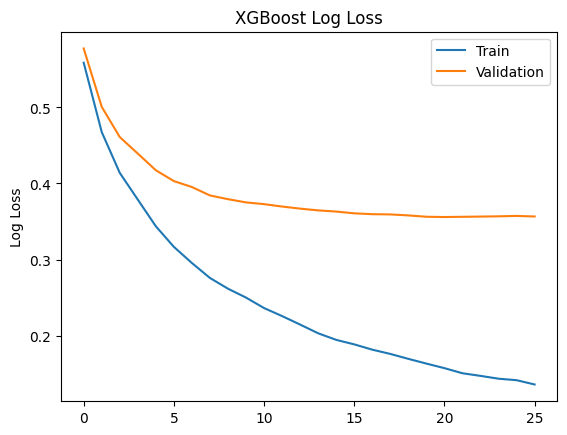

In [245]:
# plot train-val curve to ensure no overfitting
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

colsample_bytree = config.colsample_bytree
n_estimators = config.n_estimators
tree_method= "auto"

# tuning parameters
eta = config.eta
max_depth = config.max_depth
max_leaves = 2 ** max_depth

# prevent overfitting
min_child_weight = config.min_child_weight
gamma = config.gamma
subsample = config.subsample


# Use "hist" for constructing the trees, with early stopping enabled.
model = xgb.XGBClassifier(
    device="cuda" if config.if_GPU else "cpu",
    early_stopping_rounds=early_stopping_rounds,
    tree_method=tree_method,
    objective=objective,
    n_estimators=n_estimators,
    missing=np.nan,
    eval_metric=eval_metric,
    booster=booster,
    eta=eta,
    max_depth=max_depth,
    max_leaves=max_leaves,
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree)

# Fit the model, val sets are used for early stopping.
# result = model.fit(cp.array(X_train), cp.array(y_train), eval_set=[(cp.array(X_train), cp.array(y_train)), (cp.array(X_val), cp.array(y_val))], sample_weight=sample_weights, verbose=True)
result = model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], sample_weight=sample_weights, verbose=True)

# check overfitting
results = result.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [246]:
%%time
# finally train with all traing + val, and change to dart booster
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y
)

# booster = "dart"  # update booster to dart
booster = "gbtree"

# Use "hist" for constructing the trees, with early stopping enabled.
model = xgb.XGBClassifier(
    device="cuda" if config.if_GPU else "cpu",
    tree_method=tree_method,
    objective=objective,
    n_estimators=n_estimators,
    missing=np.nan,
    eval_metric=eval_metric,
    booster=booster,
    eta=eta,
    max_depth=max_depth,
    max_leaves=max_leaves,
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree)

# model.fit(cp.array(X), cp.array(y), verbose=True, sample_weight=sample_weights)
model.fit(X, y, verbose=True, sample_weight=sample_weights)

CPU times: user 6min 54s, sys: 398 ms, total: 6min 55s
Wall time: 7.72 s


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric='logloss',
              feature_types=None, gamma=0.45095519663195377, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=1024, min_child_weight=1.5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=69,
              n_jobs=None, num_parallel_tree=None, ...)

In [247]:
# train
preds = model.predict(cp.array(X_train))

# 0.9130316495873766
f1_score(y_train, preds)

0.9242337647783943

In [248]:
# val
preds = model.predict(cp.array(X_val))

# 0.9130316495873766
f1_score(y_val, preds)

0.9227985524728589

In [249]:
# predict on test set
preds = model.predict(cp.array(X_test))

# 0.9196223751544026
f1_score(y_test, preds)

0.9181217768931512

In [250]:
# Threshold Moving/Tuning
from numpy import arange
from numpy import argmax

yhat = model.predict_proba(cp.array(X_val))

# keep probabilities for the positive outcome only
probs = yhat[:, 1]

# define thresholds
thresholds = arange(0, 1, 0.001)

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')


# evaluate each threshold
scores = [f1_score(y_val, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)

best_thresh = thresholds[ix]

print('Best performing threshold=%.3f with best F-Score=%.5f' % (best_thresh, scores[ix]))

In [ ]:
%%time
# predict on test set
prob = model.predict_proba(cp.array(X_test))[:, 1]

preds = (prob > best_thresh).astype("int")

# 0.9228875406664908
f1_score(y_test, preds)

In [ ]:
# plot the feature importance
feature_imp = pd.DataFrame(sorted(zip(model.feature_names_in_, model.feature_importances_), key=lambda x: x[0], reverse=True), columns=['Feature', 'Value'])
fig, ax = plt.subplots()

data = feature_imp.sort_values(by="Value", ascending=False).head(50)
fig.set_size_inches(18.5, 10.5)

sns.barplot(x="Value", y="Feature", data=data)
ax.set_title('Feature Importance By Weight')
ax.set_xlabel('importance score')
ax.set_ylabel('features')
ax.yaxis.set_visible(True)
ax.xaxis.set_visible(True)
fig.patch.set_facecolor('white')
# plt.savefig(f'../data/feature_importance_by_weight.png', bbox_inches='tight')

In [ ]:
# select features
useless_cols = feature_imp.sort_values(by="Value", ascending=False).loc[feature_imp.sort_values(by="Value", ascending=False).Value == 0, "Feature"].tolist()
useless_cols

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

In [ ]:
shap.summary_plot(shap_values.values, X_test, max_display=10, show=False, plot_type="dot", plot_size=[10,10])


In [ ]:
"""
After all the analysis, we have built the end to end pipeline for production
"""

In [ ]:
# run pipeline
df_raw = pd.read_excel("../data/Assessment.xlsx",
                       engine='openpyxl',
                       sheet_name=1)

pipe = E2EPipeline()
data = pipe.preprocess(df_raw)
f1 = pipe.train(data)
print(f"the f1 score is: {f1}")

In [ ]:
# !ls -lh